In [13]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, fsolve
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import pylab as pl

In [14]:
# Model Functions


def sir_model_ivp(t, y, beta, gamma):
    """Standard SIR model for solve_ivp"""
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]


def sir_model_closed_pop_ivp(t, y, beta, gamma, N):
    """SIR model for closed population"""
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]


def sir_demography_ivp(t, y, beta, gamma, mu):
    """SIR model with births and deaths"""
    S, I, R = y
    dSdt = mu - beta * S * I - mu * S
    dIdt = beta * S * I - gamma * I - mu * I
    dRdt = gamma * I - mu * R
    return [dSdt, dIdt, dRdt]


def sir_mortality_ivp(t, y, beta, gamma, mu, rho):
    """SIR model with disease-induced mortality"""
    S, I, R = y
    N = S + I + R
    inf = beta * S * I / N if N > 0 else 0.0
    removal = (gamma + mu) / (1.0 - rho)
    dSdt = mu * N - inf - mu * S
    dIdt = inf - removal * I
    dRdt = gamma * I - mu * R
    return [dSdt, dIdt, dRdt]


def seir_model_ivp(t, y, beta, gamma, mu, sigma):
    """SEIR model with demographics"""
    S, E, I, R = y
    dSdt = mu - beta * S * I - mu * S
    dEdt = beta * S * I - (mu + sigma) * E
    dIdt = sigma * E - (mu + gamma) * I
    dRdt = gamma * I - mu * R
    return [dSdt, dEdt, dIdt, dRdt]


def seir_seasonal_ivp(t, y, beta0, beta1, gamma, mu, sigma):
    """SEIR model with seasonal forcing"""
    S, E, I, R = y
    beta_t = beta0 * (1 + beta1 * np.cos(2 * np.pi * t / 365.0))
    dSdt = mu - beta_t * S * I - mu * S
    dEdt = beta_t * S * I - (mu + sigma) * E
    dIdt = sigma * E - (mu + gamma) * I
    dRdt = gamma * I - mu * R
    return [dSdt, dEdt, dIdt, dRdt]

In [15]:
# Vaccination Strategy Models


def sir_pediatric_vaccination_ivp(t, y, beta, gamma, p, N):
    """SIR model with pediatric vaccination"""
    S, I, R = y
    beta_effective = beta * (1 - p)
    dSdt = -beta_effective * S * I / N
    dIdt = beta_effective * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]


def sir_mass_vaccination_ivp(t, y, beta, gamma, u, N):
    """SIR model with mass vaccination"""
    S, I, R, V = y  # V tracks vaccinated individuals
    dSdt = -beta * S * I / N - u
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    dVdt = u

    if S <= 0:
        dSdt = 0
        dVdt = 0

    return [dSdt, dIdt, dRdt, dVdt]

In [16]:
# Solver Utils


def solve_epidemic_model(model_func, initial_conditions, t_span, args, method="RK45"):
    """
    Generic epidemic model solver
    Returns: time array, solution array (transposed for easy indexing)
    """
    if isinstance(t_span, (list, tuple)) and len(t_span) == 2:
        # If t_span is [start, end], create evaluation points
        t_eval = np.linspace(t_span[0], t_span[1], 1000)
    else:
        # If t_span is already an array of evaluation points
        t_eval = t_span
        t_span = [t_span[0], t_span[-1]]

    sol = solve_ivp(
        model_func,
        t_span,
        initial_conditions,
        t_eval=t_eval,
        args=args,
        method=method,
        rtol=1e-8,
        atol=1e-10,
    )
    return sol.t, sol.y.T


def calculate_R0(model_type, beta, gamma, mu=0, sigma=0):
    """Calculate R0 for different model types"""
    if model_type in ["sir", "sir_demography"]:
        return beta / (gamma + mu)
    elif model_type == "seir":
        return (beta * sigma) / ((mu + sigma) * (mu + gamma))
    else:
        raise ValueError(f"Unknown model type: {model_type}")

In [17]:
# Plotting Utils


def setup_parameter_sweep_subplots(param1_values, param2_values, figsize=(20, 15)):
    """Create subplot grid for parameter sweeps"""
    fig, axes = plt.subplots(
        nrows=len(param1_values),
        ncols=len(param2_values),
        figsize=figsize,
        sharex=True,
        sharey=True,
    )
    return fig, axes


def plot_epidemic_timeseries(
    ax,
    t,
    solution,
    param1,
    param2,
    i,
    j,
    param1_values,
    param2_values,
    param1_name,
    param2_name,
    R0,
    model_type="sir",
):
    """Plot epidemic time series on a single subplot"""

    if model_type == "sir":
        colors = ["b-", "r-", "g-"]
        labels = ["Susceptible", "Infected", "Recovered"]
    elif model_type == "seir":
        colors = ["b-", "orange", "r-", "g-"]
        labels = ["Susceptible", "Exposed", "Infected", "Recovered"]

    for k, (color, label) in enumerate(zip(colors, labels)):
        ax.plot(t, solution[:, k], color, alpha=0.7, linewidth=2, label=label)

    # Epidemic classification
    if model_type == "sir":
        peak_infection = np.max(solution[:, 1])
        if R0 <= 1:
            epidemic_status = "No Epidemic"
        elif peak_infection < 0.1:
            epidemic_status = "Mild"
        elif peak_infection < 0.3:
            epidemic_status = "Moderate"
        else:
            epidemic_status = "Severe"
        title = f"R₀ = {R0:.2f}\n({epidemic_status})"
    else:
        title = f"R₀ = {R0:.2f}"

    ax.set_title(title, fontsize=15)
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=12)

    if i == len(param1_values) - 1:
        ax.set_xlabel(f"Time (days)\n{param2_name} = {param2}", fontsize=12)
    if j == 0:
        ax.set_ylabel(f"Population Fraction\n{param1_name} = {param1}", fontsize=12)


def plot_phase_portrait(
    ax,
    solution,
    param1,
    param2,
    i,
    j,
    param1_values,
    param2_values,
    param1_name,
    param2_name,
    R0,
    S0_initial,
    I0_initial,
):
    """Plot phase portrait on a single subplot"""

    # Plot trajectory
    ax.plot(solution[:, 0], solution[:, 1], "blue", alpha=0.7, linewidth=2)
    ax.scatter(S0_initial, I0_initial, c="blue", s=30)

    # Add boundary lines
    ax.plot([0, 1], [1, 0], "gray", alpha=0.4, linewidth=2, label="S+I=1")
    ax.plot([0, 1], [0, 0], "gray", alpha=0.4, linewidth=2, label="I=0")
    ax.plot([0, 0], [0, 1], "gray", alpha=0.4, linewidth=2, label="S=0")

    # Add critical threshold line
    if R0 > 1:
        ax.axvline(
            x=1 / R0,
            color="purple",
            linestyle="--",
            alpha=0.7,
            linewidth=2,
            label="dI/dt=0",
        )
        ax.text(
            1 / R0 + 0.05, 0.8, f"S*=1/R₀", color="purple", fontsize=10, rotation=90
        )

    # Add equilibrium point
    if R0 > 1:
        # Calculate equilibrium for demography model
        S_eq = 1 / R0
        mu = 1 / 70  # Default value
        I_eq = mu * (R0 - 1) / param2  # Assuming param2 is beta
        ax.scatter(
            S_eq,
            I_eq,
            c="red",
            s=120,
            marker="o",
            label="Equilibrium",
            zorder=5,
            edgecolors="black",
        )

    epidemic_type = "Epidemic" if R0 > 1 else "No Epidemic"
    ax.set_title(f"R₀ = {R0:.2f}\n({epidemic_type})", fontsize=13, pad=15)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=10)

    if i == len(param1_values) - 1:
        ax.set_xlabel(f"S (Susceptible)\n{param2_name} = {param2}", fontsize=11)
    if j == 0:
        ax.set_ylabel(f"I (Infected)\n{param1_name} = {param1}", fontsize=11)


def finalize_parameter_sweep_figure(fig, axes, title, show_legend=True):
    """Add legend and title to parameter sweep figure"""
    if show_legend:
        handles, labels = axes[0, 0].get_legend_handles_labels()
        fig.legend(
            handles, labels, loc="center right", bbox_to_anchor=(0.98, 0.5), fontsize=14
        )

    plt.subplots_adjust(
        left=0.08, right=0.90, top=0.92, bottom=0.08, wspace=0.2, hspace=0.3
    )
    plt.suptitle(title, fontsize=22)

In [35]:
# Analysis Utils


def run_sir_parameter_sweep():
    """Run standard SIR parameter sweep"""
    beta_values = [1, 2.5, 3]
    gamma_values = [0.5, 0.1, 1.5]

    S0, I0, R0_init = 0.99, 0.01, 0.0
    initial_conditions = [S0, I0, R0_init]
    t_max = 15

    fig, axes = setup_parameter_sweep_subplots(gamma_values, beta_values)

    for i, gamma in enumerate(gamma_values):
        for j, beta in enumerate(beta_values):
            R0 = calculate_R0("sir", beta, gamma)
            t, solution = solve_epidemic_model(
                sir_model_ivp, initial_conditions, [0, t_max], (beta, gamma)
            )
            plot_epidemic_timeseries(
                axes[i, j],
                t,
                solution,
                gamma,
                beta,
                i,
                j,
                gamma_values,
                beta_values,
                "γ",
                "β",
                R0,
                "sir",
            )

    finalize_parameter_sweep_figure(fig, axes, "SIR Model Parameter Sweep")
    plt.show()


def run_sir_phase_portraits():
    """Run SIR phase portrait analysis"""
    beta_values = [1, 2.5, 3]
    gamma_values = [0.5, 0.1, 1.5]
    S0_list = np.linspace(0.1, 1, 10)
    t_max = 15

    fig, axes = setup_parameter_sweep_subplots(gamma_values, beta_values)

    for i, gamma in enumerate(gamma_values):
        for j, beta in enumerate(beta_values):
            R0 = calculate_R0("sir", beta, gamma)

            for S0_var in S0_list:
                I0_var = 1 - S0_var
                R0_var = 0

                # High infection trajectory
                t, result = solve_epidemic_model(
                    sir_model_ivp, [S0_var, I0_var, R0_var], [0, t_max], (beta, gamma)
                )
                plot_phase_portrait(
                    axes[i, j],
                    result,
                    gamma,
                    beta,
                    i,
                    j,
                    gamma_values,
                    beta_values,
                    "γ",
                    "β",
                    R0,
                    S0_var,
                    I0_var,
                )

                # Low infection trajectory (if epidemic possible)
                if S0_var > 1 / R0 and R0 > 1:
                    I0_small = 0.001
                    R0_small = 1 - I0_small - S0_var
                    t, result = solve_epidemic_model(
                        sir_model_ivp,
                        [S0_var, I0_small, R0_small],
                        [0, t_max],
                        (beta, gamma),
                    )
                    axes[i, j].plot(
                        result[:, 0], result[:, 1], "b-", alpha=0.6, linewidth=2
                    )
                    axes[i, j].scatter(S0_var, I0_small, c="blue", s=30)

    finalize_parameter_sweep_figure(
        fig, axes, "Phase Space Diagrams: S vs I Trajectories", show_legend=False
    )
    plt.show()


def run_sir_demography_analysis():
    """Run SIR with demography analysis"""
    beta_values = [1.5, 2.5, 3.5]
    gamma_values = [0.6, 1.2, 1.8]
    mu = 1 / 70

    S0, I0, R0_init = 0.99, 0.01, 0.0
    initial_conditions = [S0, I0, R0_init]
    t_span = (0, 200)
    t_eval = np.linspace(0, 200, 800)

    # Time series plots
    fig, axes = setup_parameter_sweep_subplots(gamma_values, beta_values)

    for i, gamma in enumerate(gamma_values):
        for j, beta in enumerate(beta_values):
            R0 = calculate_R0("sir_demography", beta, gamma, mu)
            t, solution = solve_epidemic_model(
                sir_demography_ivp, initial_conditions, t_eval, (beta, gamma, mu)
            )
            plot_epidemic_timeseries(
                axes[i, j],
                t,
                solution,
                gamma,
                beta,
                i,
                j,
                gamma_values,
                beta_values,
                "γ",
                "β",
                R0,
                "sir",
            )
            # Change x-axis label for years
            if i == len(gamma_values) - 1:
                axes[i, j].set_xlabel(f"t (years)\\nβ = {beta}", fontsize=12)
            if j == 0:
                axes[i, j].set_ylabel(f"Fraction of people\\nγ = {gamma}", fontsize=12)

    finalize_parameter_sweep_figure(fig, axes, "SIR Model with Demography")
    plt.show()

    # Phase portraits
    fig2, axes2 = setup_parameter_sweep_subplots(gamma_values, beta_values)
    S0_list = np.linspace(0.1, 1.0, 10)

    for i, gamma in enumerate(gamma_values):
        for j, beta in enumerate(beta_values):
            R0 = calculate_R0("sir_demography", beta, gamma, mu)

            for S0_val in S0_list:
                # High infection start
                I0_high = 1 - S0_val
                R0_high = 0.0
                if I0_high > 0:
                    t, result = solve_epidemic_model(
                        sir_demography_ivp,
                        [S0_val, I0_high, R0_high],
                        [0, 100],
                        (beta, gamma, mu),
                    )
                    plot_phase_portrait(
                        axes2[i, j],
                        result,
                        gamma,
                        beta,
                        i,
                        j,
                        gamma_values,
                        beta_values,
                        "γ",
                        "β",
                        R0,
                        S0_val,
                        I0_high,
                    )

                # Low infection start
                if (S0_val > (1 / R0 + 0.1)) and (R0 > 1):
                    I0_low = 0.001
                    R0_low = 1 - S0_val - I0_low
                    if R0_low >= 0:
                        t, result = solve_epidemic_model(
                            sir_demography_ivp,
                            [S0_val, I0_low, R0_low],
                            [0, 100],
                            (beta, gamma, mu),
                        )
                        axes2[i, j].plot(
                            result[:, 0], result[:, 1], "blue", alpha=0.6, linewidth=2
                        )
                        axes2[i, j].scatter(S0_val, I0_low, c="blue", s=40, alpha=0.8)

    finalize_parameter_sweep_figure(
        fig2, axes2, "Phase Space Diagrams - Demography", show_legend=False
    )
    plt.show()


def run_seir_analysis():
    """Run SEIR model analysis"""
    beta_values = [1.5, 2.5, 3.5]
    gamma = 0.25
    mu = 1 / 70
    sigma_values = [0.05, 0.15, 0.25]

    S0, I0, E0, R0_init = 0.90, 0.05, 0.05, 0.0
    initial_conditions = [S0, E0, I0, R0_init]
    t_span = (0, 365)
    t_eval = np.linspace(0, 365, 2000)

    fig, axes = setup_parameter_sweep_subplots(beta_values, sigma_values)

    for i, beta in enumerate(beta_values):
        for j, sigma in enumerate(sigma_values):
            R0 = calculate_R0("seir", beta, gamma, mu, sigma)
            t, solution = solve_epidemic_model(
                seir_model_ivp, initial_conditions, t_eval, (beta, gamma, mu, sigma)
            )
            plot_epidemic_timeseries(
                axes[i, j],
                t,
                solution,
                beta,
                sigma,
                i,
                j,
                beta_values,
                sigma_values,
                "β",
                "σ",
                R0,
                "seir",
            )

    finalize_parameter_sweep_figure(fig, axes, "SEIR Model")
    plt.show()


def run_seir_seasonal_analysis():
    """Run SEIR seasonal analysis"""
    beta_values = [1.5, 2.5, 3.5]
    gamma = 0.5
    mu = 1 / 70
    sigma_values = [0.05, 0.15, 0.25]
    beta1_values = [0.0, 0.3, 0.6, 0.9]

    S0, I0, E0 = 0.99, 1e-4, 1e-4
    R0_init = 1 - S0 - I0 - E0
    initial_conditions = [S0, E0, I0, R0_init]

    t_span = (0, 5 * 365)
    t_eval = np.linspace(0, 365 * 5, 2000)

    # Seasonal forcing comparison
    fig1, axes1 = plt.subplots(
        nrows=2, ncols=2, figsize=(16, 12), sharex=True, sharey=True
    )
    axes1 = axes1.flatten()

    beta0_fixed = 2.5
    sigma_fixed = 0.15

    for i, beta1 in enumerate(beta1_values):
        R0 = calculate_R0("seir", beta0_fixed, gamma, mu, sigma_fixed)
        t, solution = solve_epidemic_model(
            seir_seasonal_ivp,
            initial_conditions,
            t_eval,
            (beta0_fixed, beta1, gamma, mu, sigma_fixed),
        )

        # Plot compartments
        axes1[i].plot(
            t / 365, solution[:, 0], "b-", alpha=0.8, linewidth=2, label="Susceptible"
        )
        axes1[i].plot(
            t / 365, solution[:, 1], "orange", alpha=0.8, linewidth=2, label="Exposed"
        )
        axes1[i].plot(
            t / 365, solution[:, 2], "r-", alpha=0.8, linewidth=2, label="Infected"
        )
        axes1[i].plot(
            t / 365, solution[:, 3], "g-", alpha=0.8, linewidth=2, label="Recovered"
        )

        axes1[i].set_ylim(-0.05, 1.05)
        axes1[i].set_title(f"β₁ = {beta1} (R₀ = {R0:.2f})", fontsize=14)
        axes1[i].tick_params(labelsize=11)
        axes1[i].grid(True, alpha=0.3)

        if i >= 2:
            axes1[i].set_xlabel("Time (years)", fontsize=12)
        if i % 2 == 0:
            axes1[i].set_ylabel("Population Fraction", fontsize=12)

    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.suptitle("Effect of Seasonal Forcing Strength (β₁)", fontsize=16, y=0.98)
    handles, labels = axes1[0].get_legend_handles_labels()
    fig1.legend(
        handles, labels, loc="center right", bbox_to_anchor=(0.98, 0.5), fontsize=12
    )
    plt.show()

    # Parameter sweep with seasonal forcing
    fig2, axes2 = setup_parameter_sweep_subplots(beta_values, sigma_values)
    beta1_moderate = 0.6

    for i, beta0 in enumerate(beta_values):
        for j, sigma in enumerate(sigma_values):
            R0 = calculate_R0("seir", beta0, gamma, mu, sigma)
            t, solution = solve_epidemic_model(
                seir_seasonal_ivp,
                initial_conditions,
                t_eval,
                (beta0, beta1_moderate, gamma, mu, sigma),
            )
            plot_epidemic_timeseries(
                axes2[i, j],
                t / 365,
                solution,
                beta0,
                sigma,
                i,
                j,
                beta_values,
                sigma_values,
                "β₀",
                "σ",
                R0,
                "seir",
            )

            if i == len(beta_values) - 1:
                axes2[i, j].set_xlabel(f"Time (years)\\nσ = {sigma}", fontsize=12)

    finalize_parameter_sweep_figure(
        fig2,
        axes2,
        f"SEIR Parameter Sweep with Seasonal Forcing (β₁ = {beta1_moderate})",
    )
    plt.show()


def fit_sir_to_data():
    """Fit SIR model to influenza outbreak data"""
    # Data
    days = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
    infected_data = np.array(
        [1, 3, 8, 28, 75, 221, 291, 255, 235, 190, 125, 70, 28, 12, 5]
    )
    N = 763

    def objective_function(params):
        beta, gamma = params
        S0, I0, R0 = N - 1, 1, 0
        try:
            t, solution = solve_epidemic_model(
                sir_model_closed_pop_ivp, [S0, I0, R0], days, (beta, gamma, N)
            )
            I_predicted = solution[:, 1]
            return np.sum((I_predicted - infected_data) ** 2)
        except:
            return 1e10

    # Fit model
    result = minimize(
        objective_function,
        [1.5, 0.4],
        bounds=[(0.1, 5.0), (0.1, 1.0)],
        method="L-BFGS-B",
    )
    beta_fitted, gamma_fitted = result.x
    R0_fitted = beta_fitted / gamma_fitted

    # Generate predictions
    S0, I0, R0_init = N - 1, 1, 0
    t_data, sol_fitted = solve_epidemic_model(
        sir_model_closed_pop_ivp,
        [S0, I0, R0_init],
        days,
        (beta_fitted, gamma_fitted, N),
    )
    t_smooth = np.linspace(0, 14, 100)
    t_smooth_arr, sol_smooth = solve_epidemic_model(
        sir_model_closed_pop_ivp,
        [S0, I0, R0_init],
        t_smooth,
        (beta_fitted, gamma_fitted, N),
    )

    # Plots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

    # Model fit
    ax1.plot(days, infected_data, "ro", markersize=8, label="Observed data", zorder=3)
    ax1.plot(
        t_smooth_arr,
        sol_smooth[:, 1],
        "b-",
        linewidth=2,
        label=f"SIR model (R₀={R0_fitted:.2f})",
        zorder=2,
    )
    ax1.set_xlabel("Days")
    ax1.set_ylabel("Number of Infected Boys")
    ax1.set_title("SIR Model Fit to Influenza Outbreak Data (Method: RK45)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # All compartments
    ax2.plot(t_smooth_arr, sol_smooth[:, 0], "g-", linewidth=2, label="Susceptible (S)")
    ax2.plot(t_smooth_arr, sol_smooth[:, 1], "r-", linewidth=2, label="Infectious (I)")
    ax2.plot(t_smooth_arr, sol_smooth[:, 2], "b-", linewidth=2, label="Recovered (R)")
    ax2.plot(days, infected_data, "ro", markersize=4, alpha=0.7, label="Data")
    ax2.set_xlabel("Days")
    ax2.set_ylabel("Number of Boys")
    ax2.set_title("SIR Model: All Compartments")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Phase portrait
    ax3.plot(
        sol_smooth[:, 0], sol_smooth[:, 1], "b-", linewidth=2, label="Model trajectory"
    )
    ax3.plot(
        sol_fitted[:, 0], sol_fitted[:, 1], "ro", markersize=6, label="Data points"
    )
    ax3.set_xlabel("Number of Susceptible Boys")
    ax3.set_ylabel("Number of Infectious Boys")
    ax3.set_title("Phase Portrait (S vs I)")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return beta_fitted, gamma_fitted, R0_fitted

In [19]:
# Oscillation Utils
# FIXME: Add Reference from University of Warwrick


def run_oscillation_analysis():
    """Analyze SIR oscillations with demography"""
    mu = 1 / (70 * 365.0)  # Natural death rate (per day)
    beta = 520 / 365.0  # Transmission rate (per day)
    gamma = 1 / 7.0  # Recovery rate (per day)

    S0, I0 = 0.1, 1e-4
    R0_init = 1 - S0 - I0
    INPUT = [S0, I0, R0_init]

    R0 = beta / (gamma + mu)
    print(f"Parameters: β={beta:.4f}, γ={gamma:.4f}, μ={mu:.6f}")
    print(f"R₀ = {R0:.2f}")

    ND = 30 * 365  # 30 years in days
    t_range = np.arange(0, ND + 1, 1.0)

    # Solve using LSODA as specified
    solution = solve_ivp(
        sir_demography_ivp,
        (0, ND),
        INPUT,
        t_eval=t_range,
        args=(beta, gamma, mu),
        method="LSODA",
    )

    t_sol = solution.t
    S_sol, I_sol, R_sol = solution.y

    # Calculate equilibrium values
    S_eq = 1 / R0
    I_eq = mu * (R0 - 1) / beta
    R_eq = 1 - S_eq - I_eq

    print(f"Equilibrium: S*={S_eq:.4f}, I*={I_eq:.6f}, R*={R_eq:.4f}")

    # Plotting using pylab as in original
    pl.figure(figsize=(12, 10))
    pl.subplot(311)
    pl.plot(t_sol / 365, S_sol, "-g", label="Susceptibles", linewidth=2)
    pl.axhline(y=S_eq, color="g", linestyle="--", alpha=0.7)
    pl.title("Damped Oscillator Example - SIR with Demography")
    pl.xlabel("Time (years)")
    pl.ylabel("Susceptibles")
    pl.legend()
    pl.grid(True, alpha=0.3)

    pl.subplot(312)
    pl.plot(t_sol / 365, I_sol, "-r", label="Infectious", linewidth=2)
    pl.axhline(y=I_eq, color="r", linestyle="--", alpha=0.7, label=f"I* = {I_eq:.6f}")
    pl.xlabel("Time (years)")
    pl.ylabel("Infectious")
    pl.legend()
    pl.grid(True, alpha=0.3)

    pl.subplot(313)
    pl.plot(t_sol / 365, R_sol, "-k", label="Recovered", linewidth=2)
    pl.axhline(y=R_eq, color="k", linestyle="--", alpha=0.7)
    pl.xlabel("Time (years)")
    pl.ylabel("Recovered")
    pl.legend()
    pl.grid(True, alpha=0.3)

    pl.tight_layout()
    pl.show()

    return t_sol, S_sol, I_sol, R_sol, S_eq, I_eq, R_eq


def analyze_oscillations(t, signal, equilibrium, signal_name="Signal"):
    """Analyze oscillation characteristics using FFT"""
    # Remove equilibrium and skip initial transient
    skip = len(t) // 5  # Skip first 20% of data
    t_clean = t[skip:]
    signal_clean = signal[skip:] - equilibrium

    # FFT to find dominant frequency
    dt = t_clean[1] - t_clean[0]
    fft_vals = fft(signal_clean)
    freqs = fftfreq(len(signal_clean), dt)

    # Get positive frequencies and find peak
    pos_freqs = freqs[1 : len(freqs) // 2]
    fft_mag = np.abs(fft_vals[1 : len(freqs) // 2])
    dominant_freq = pos_freqs[np.argmax(fft_mag)]

    # Calculate period and amplitude
    period_days = 1 / dominant_freq
    period_years = period_days / 365
    amplitude = np.max(np.abs(signal_clean))

    # Find peaks for verification
    peaks, _ = find_peaks(signal_clean, height=0.1 * amplitude)
    if len(peaks) > 1:
        peak_period = np.mean(np.diff(t_clean[peaks]))
    else:
        peak_period = np.nan

    print(f"{signal_name}:")
    print(f" Period: {period_years:.2f} years ({period_days:.0f} days)")
    print(f" Frequency: {dominant_freq*365:.2f} cycles/year")
    print(f" Amplitude: {amplitude:.6f}")
    if not np.isnan(peak_period):
        print(f" Peak-to-peak period: {peak_period/365:.2f} years")
    print()

    return period_years, dominant_freq * 365, amplitude

In [20]:
# Mortality Analysis


def run_mortality_analysis():
    """Analyze SIR with disease-induced mortality"""
    beta, gamma, mu = 2.5, 0.5, 1 / 70
    S0, R0_init = 0.99, 0.0
    I0 = 1.0 - S0 - R0_init
    y0 = [S0, I0, R0_init]

    rho_values = [0.0, 0.2, 0.4, 0.6, 0.8]
    colors = ["blue", "green", "orange", "red", "purple"]
    t_eval = np.linspace(0, 50, 500)

    solutions = {}
    for rho in rho_values:
        t, solution = solve_epidemic_model(
            sir_mortality_ivp, y0, t_eval, (beta, gamma, mu, rho)
        )
        solutions[rho] = (t, solution)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Total population decline
    N0 = sum(y0)
    for rho, color in zip(rho_values, colors):
        t, solution = solutions[rho]
        N_total = np.sum(solution, axis=1)
        axes[0].plot(t, N_total / N0, color=color, linewidth=2, label=f"ρ = {rho}")

    axes[0].set_xlabel("Time (years)")
    axes[0].set_ylabel("Total population (÷ N₀)")
    axes[0].set_title("Population Decline Over Time")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Infected population
    for rho, color in zip(rho_values, colors):
        t, solution = solutions[rho]
        axes[1].plot(t, solution[:, 1], color=color, linewidth=2, label=f"ρ = {rho}")

    axes[1].set_xlabel("Time (years)")
    axes[1].set_ylabel("Infected fraction")
    axes[1].set_title("Infection Dynamics Over Time")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # All compartments for example
    rho_example = 0.4
    t, solution = solutions[rho_example]
    axes[2].plot(t, solution[:, 0], "b-", linewidth=2, label="Susceptible")
    axes[2].plot(t, solution[:, 1], "r-", linewidth=2, label="Infected")
    axes[2].plot(t, solution[:, 2], "g-", linewidth=2, label="Recovered")
    axes[2].plot(t, np.sum(solution, axis=1), "k--", linewidth=2, label="Total")
    axes[2].set_xlabel("Time (years)")
    axes[2].set_ylabel("Population fraction")
    axes[2].set_title(f"All Compartments (ρ = {rho_example})")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [21]:
# Vaccination Strategy Analysis


def run_vaccination_analysis():
    """Analyze vaccination strategies"""
    beta_fitted = 1.66
    gamma_fitted = 0.45
    N = 763
    R0_fitted = beta_fitted / gamma_fitted
    p_critical = 1 - 1 / R0_fitted

    print(f"R0 = {R0_fitted:.2f}")
    print(f"Critical vaccination coverage (p_c) = {p_critical:.2%}")

    days = np.linspace(0, 20, 150)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # Pediatric vaccination
    vaccination_levels = np.array([0, 0.2, 0.4, 0.5, 0.6, p_critical, 0.8, 0.9])
    colors_pediatric = plt.cm.viridis(np.linspace(0, 1, len(vaccination_levels)))

    for i, p in enumerate(vaccination_levels):
        S0 = (N - 1) * (1 - p)
        I0 = 1
        R0_init = (N - 1) * p
        
        t, solution = solve_epidemic_model(sir_model_closed_pop_ivp, [S0, I0, R0_init],
                                 days, (beta_fitted, gamma_fitted, N))

        R_effective = R0_fitted * (1 - p)
        label = f"p={p:.1%} (R_eff={R_effective:.2f})"
        if abs(p - p_critical) < 0.01:
            label = f"p={p:.1%} (CRITICAL)"

        ax1.plot(
            days, solution[:, 1], color=colors_pediatric[i], linewidth=2.5, label=label
        )

    ax1.set_xlabel("Days", fontsize=12)
    ax1.set_ylabel("Number of Infected Boys", fontsize=12)
    ax1.set_title(
        "Strategy 1: Pediatric Vaccination\n"
        + r"Effective transmission: $\beta_{eff} = \beta(1-p)$",
        fontsize=14,
    )
    ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=-5)

    # Mass vaccination
    vaccination_rates = [0, 10, 25, 50, 75, 100, 150, 200]
    colors_mass = plt.cm.plasma(np.linspace(0, 1, len(vaccination_rates)))

    for i, u in enumerate(vaccination_rates):
        S0, I0, R0_init, V0 = N - 1, 1, 0, 0

        t, solution = solve_epidemic_model(
            sir_mass_vaccination_ivp,
            [S0, I0, R0_init, V0],
            days,
            (beta_fitted, gamma_fitted, u, N),
        )

        ax2.plot(
            days,
            solution[:, 1],
            color=colors_mass[i],
            linewidth=2.5,
            label=f"u={u} boys/day",
        )

    ax2.set_xlabel("Days", fontsize=12)
    ax2.set_ylabel("Number of Infected Boys", fontsize=12)
    ax2.set_title(
        "Strategy 2: Random Mass Vaccination During Outbreak\\n"
        + "Emergency response with vaccination rate u",
        fontsize=14,
    )
    ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(bottom=-5)

    plt.tight_layout()
    plt.show()

### Problem 1

Problem 1: Numerical Integration of SIR Model

1.1 Parameter Sweep: Epidemic vs No Epidemic Scenarios


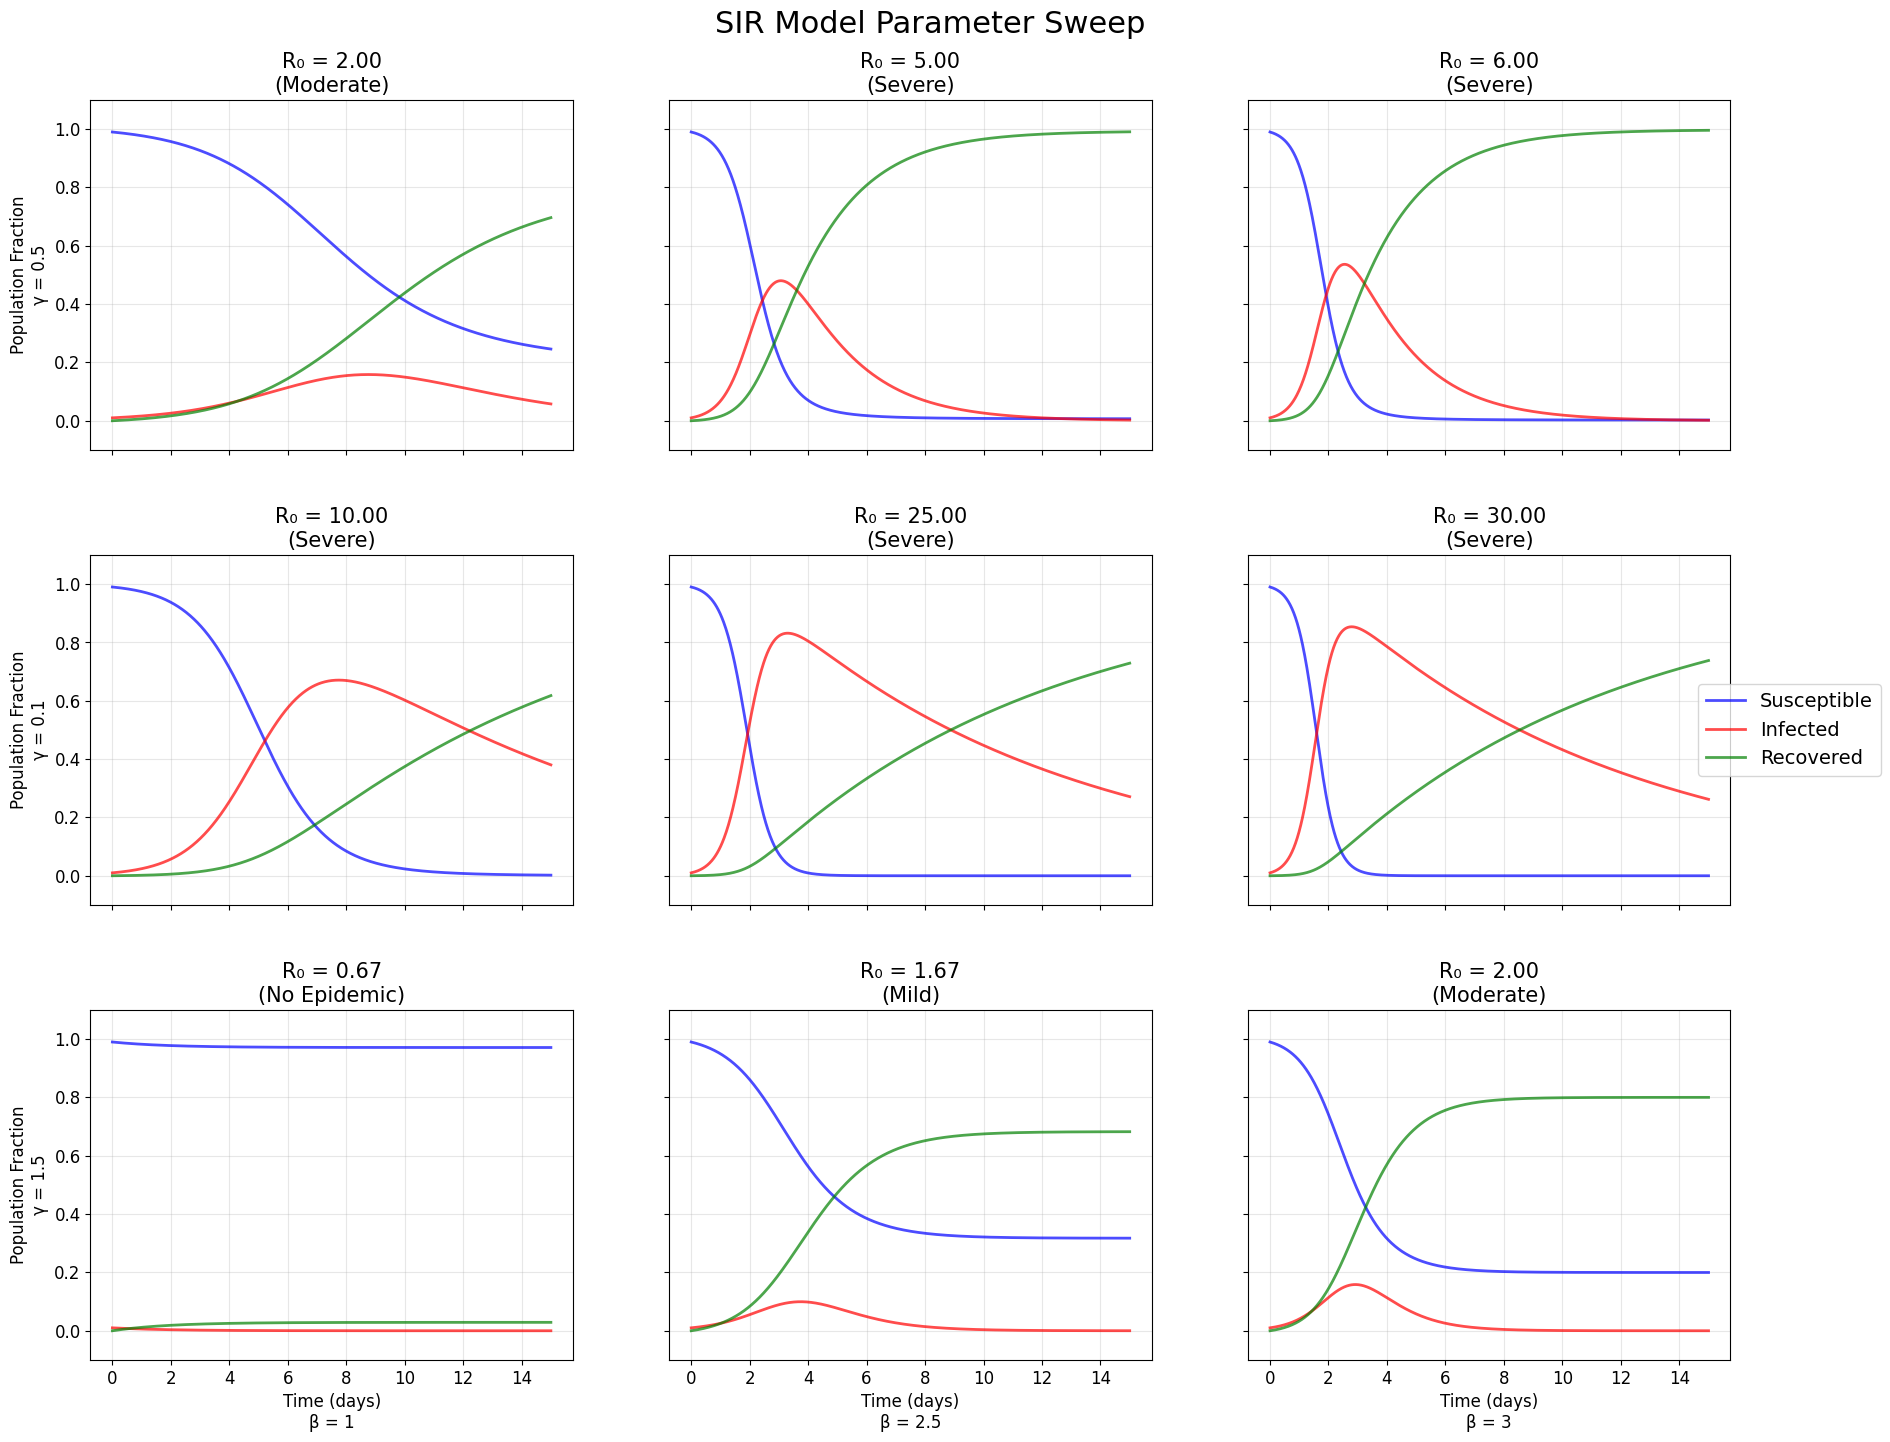


1.2 Phase Space Analysis


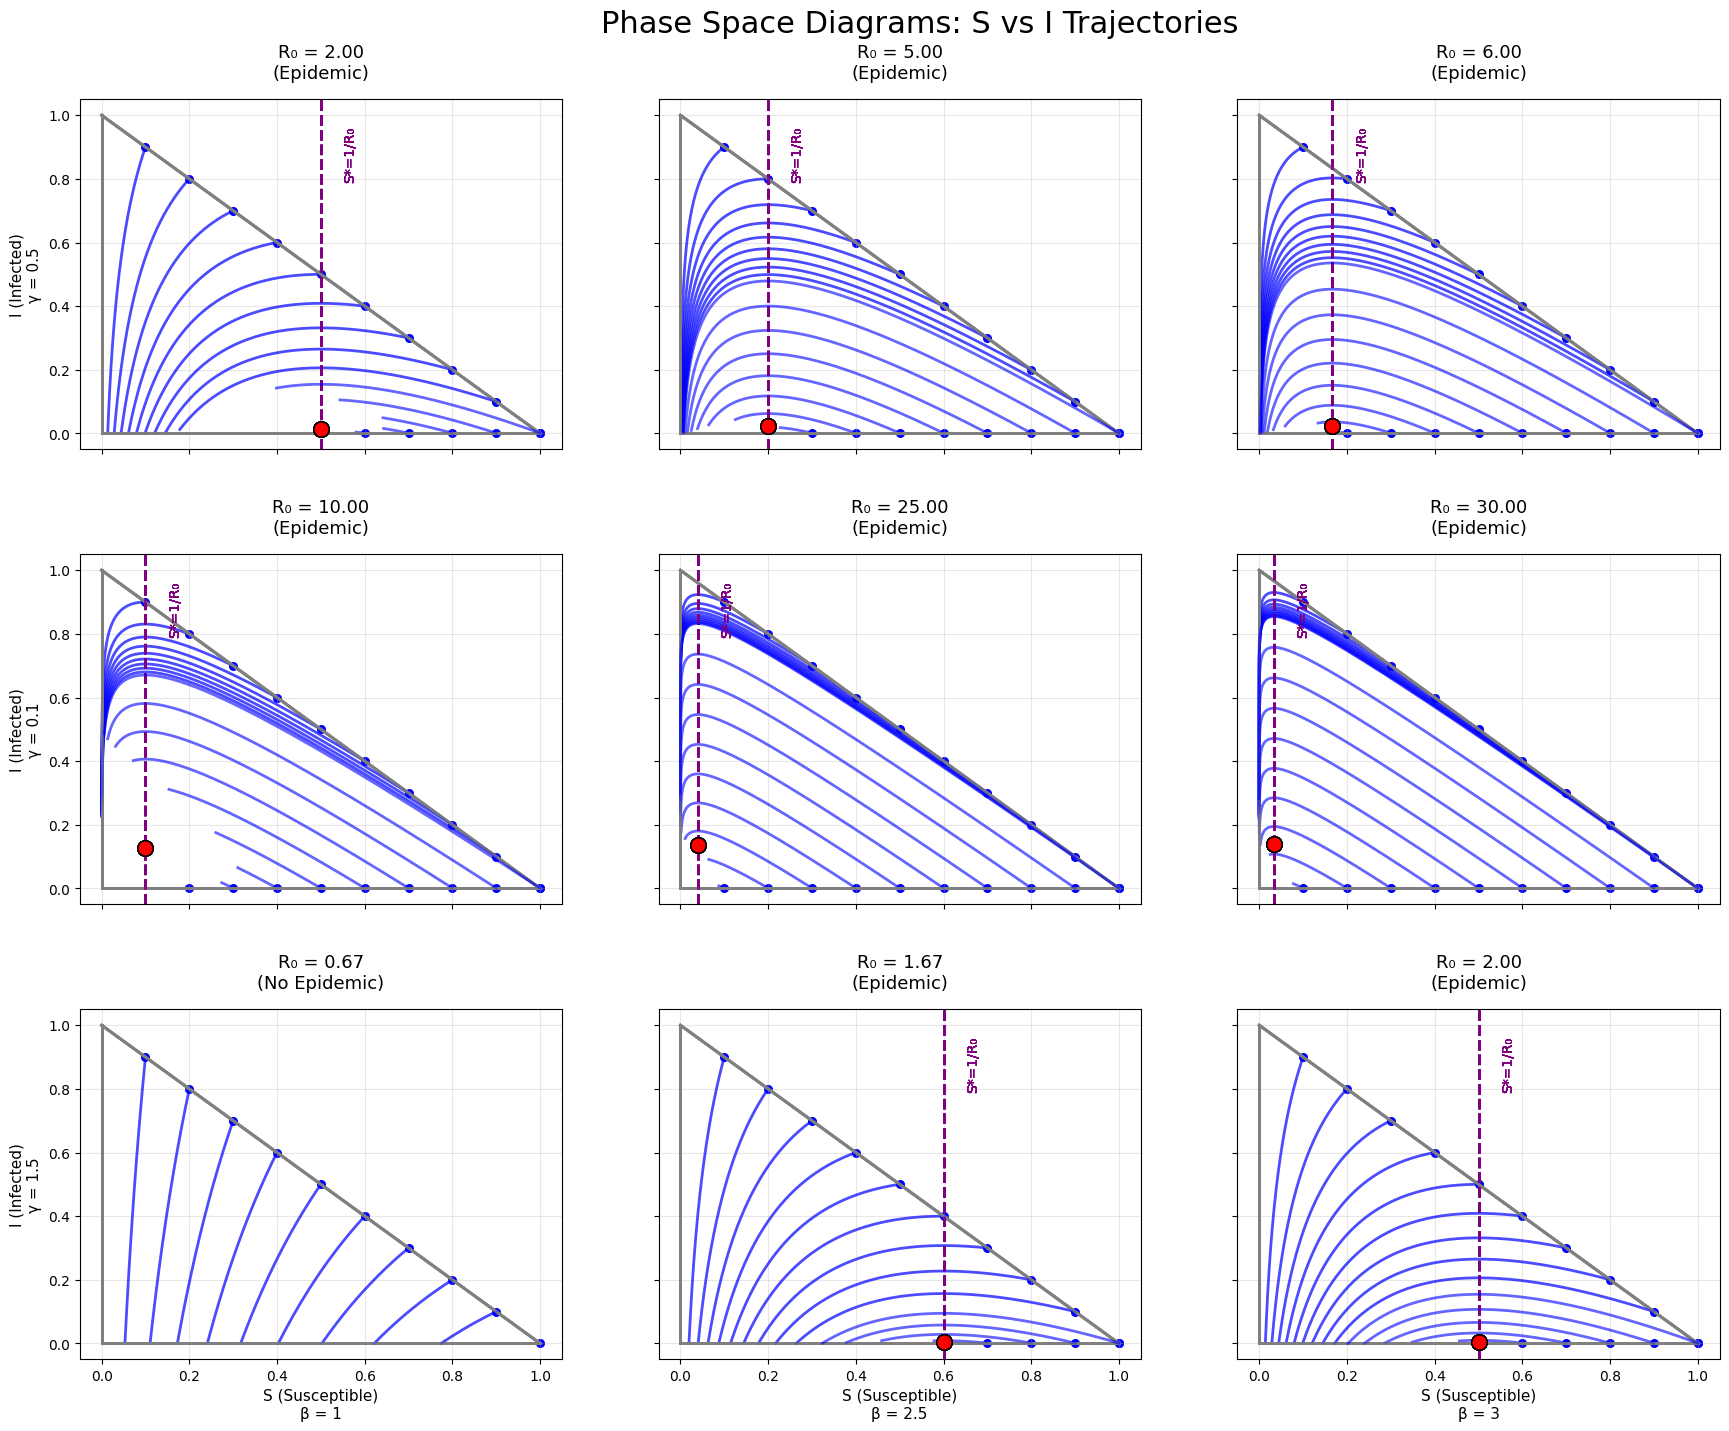


1.3 Model Fitting to Influenza Outbreak Data


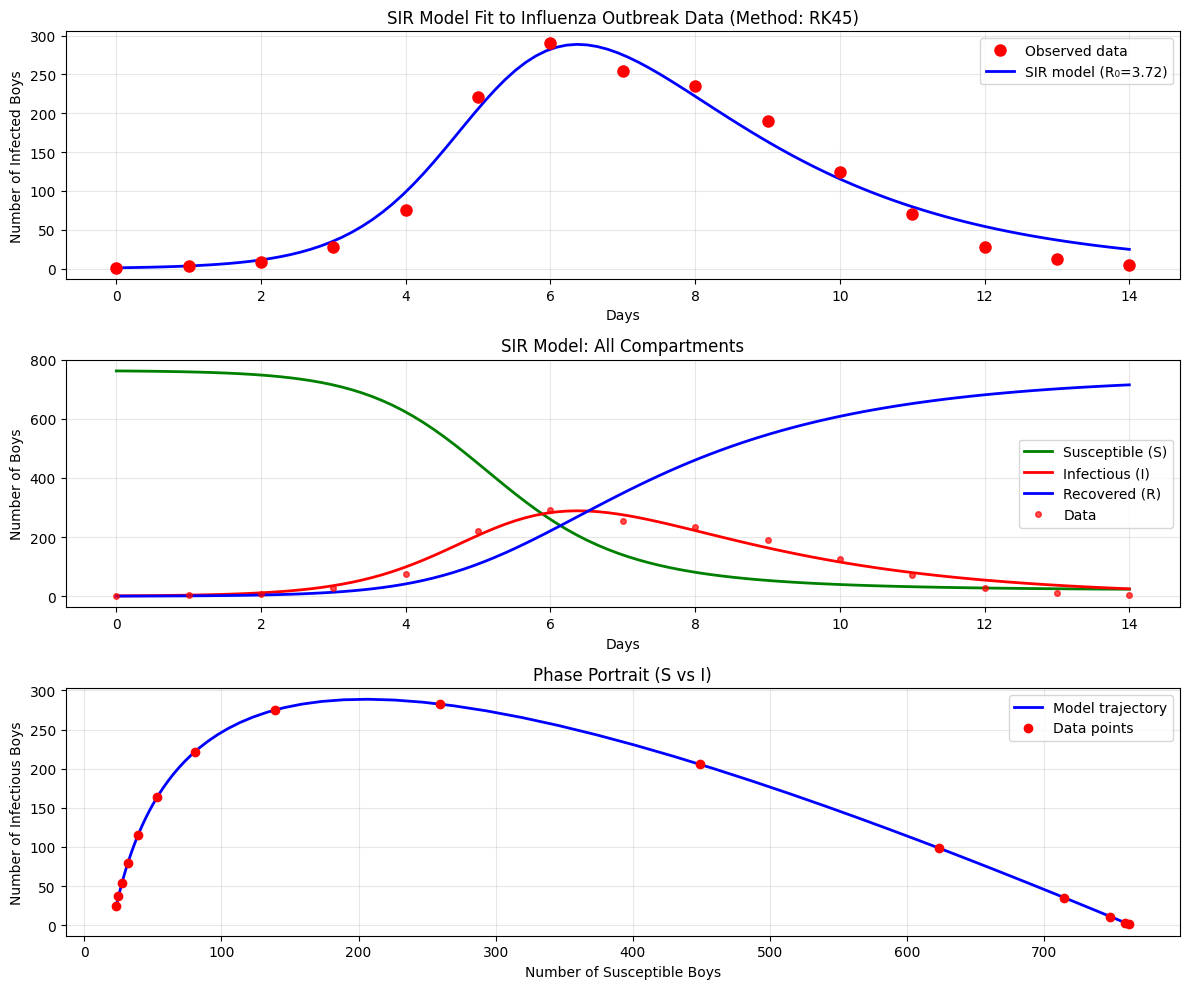


Fitted Parameters: β=1.665, γ=0.448
Basic Reproduction Number: R₀=3.72

1.4 Vaccination Strategy Analysis
R0 = 3.69
Critical vaccination coverage (p_c) = 72.89%


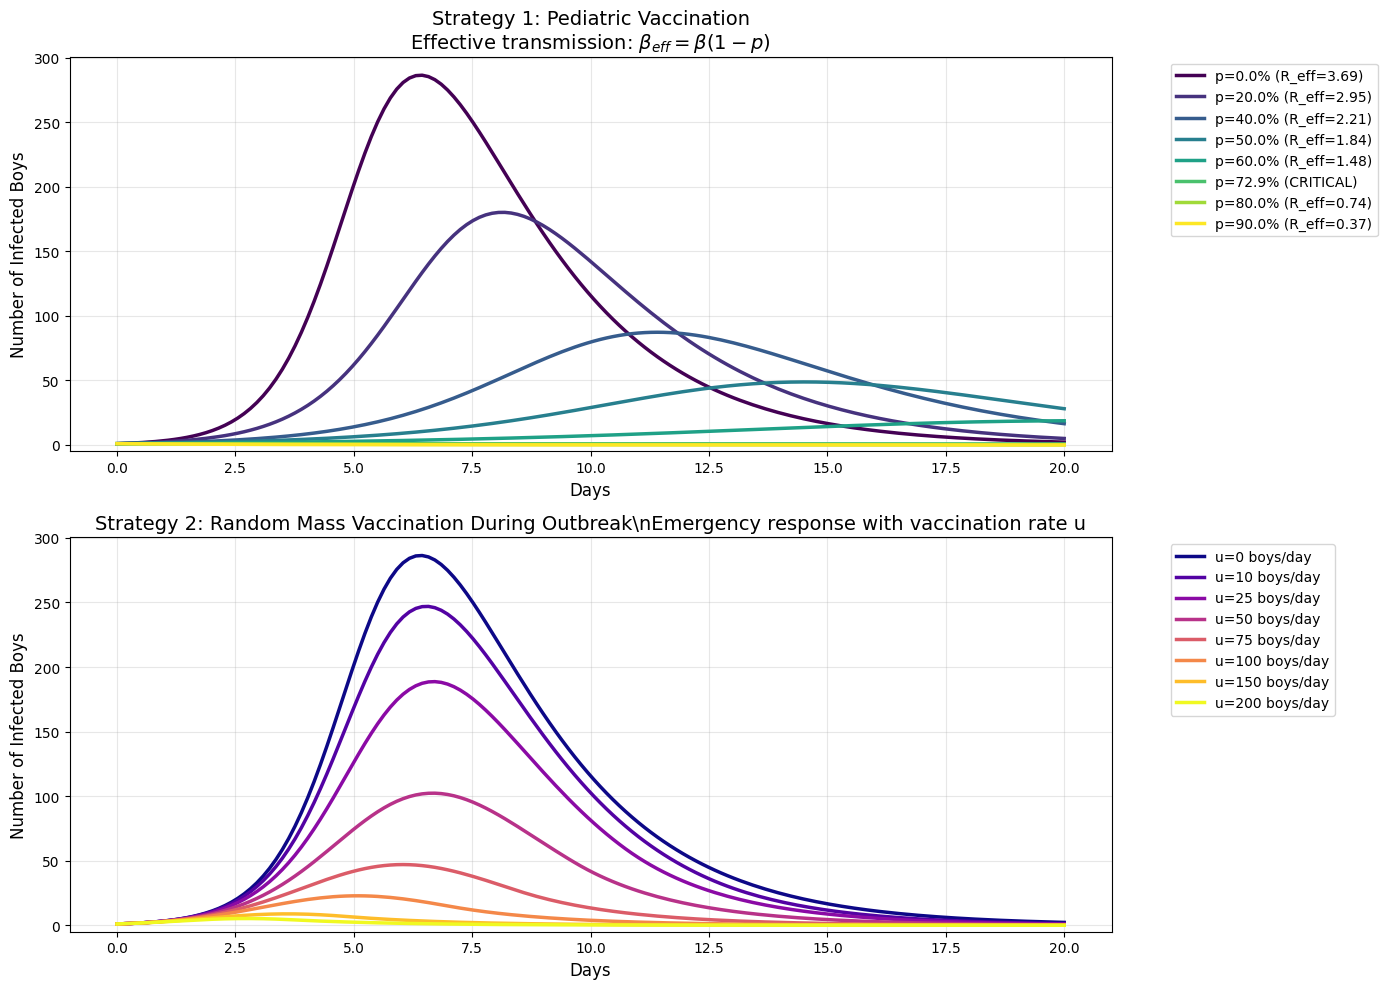

In [22]:
# Main Execution


def p1():
    print("Problem 1: Numerical Integration of SIR Model")

    print("\n1.1 Parameter Sweep: Epidemic vs No Epidemic Scenarios")
    run_sir_parameter_sweep()

    print("\n1.2 Phase Space Analysis")
    run_sir_phase_portraits()

    print("\n1.3 Model Fitting to Influenza Outbreak Data")
    beta_fitted, gamma_fitted, R0_fitted = fit_sir_to_data()
    print(f"\nFitted Parameters: β={beta_fitted:.3f}, γ={gamma_fitted:.3f}")
    print(f"Basic Reproduction Number: R₀={R0_fitted:.2f}")

    print("\n1.4 Vaccination Strategy Analysis")
    run_vaccination_analysis()


p1()

### Problem 2

Problem 2: Demography
\n2.1 SIR Model with Birth and Death Rates


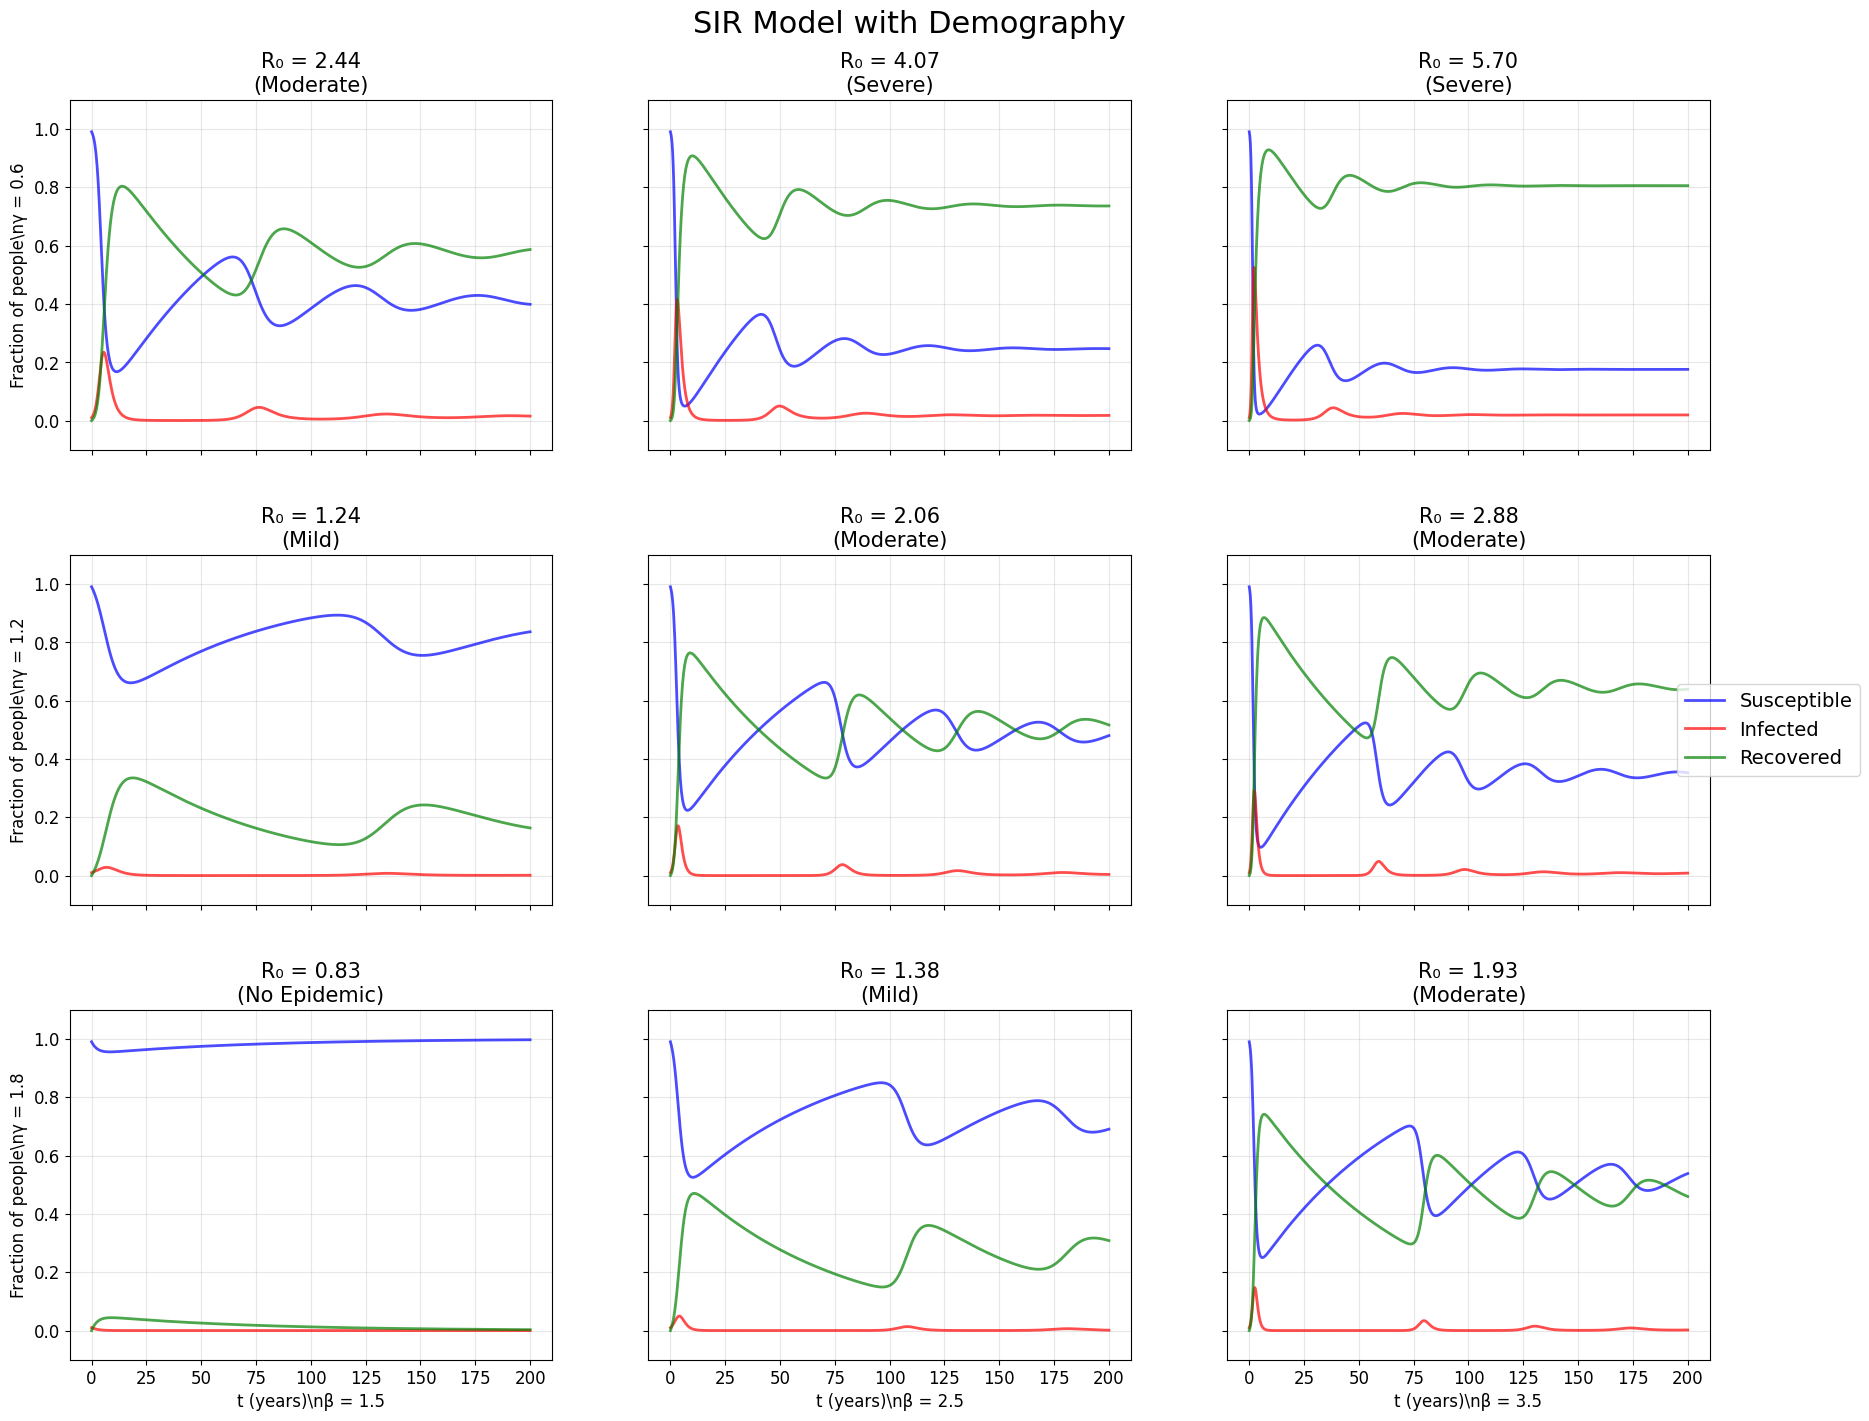

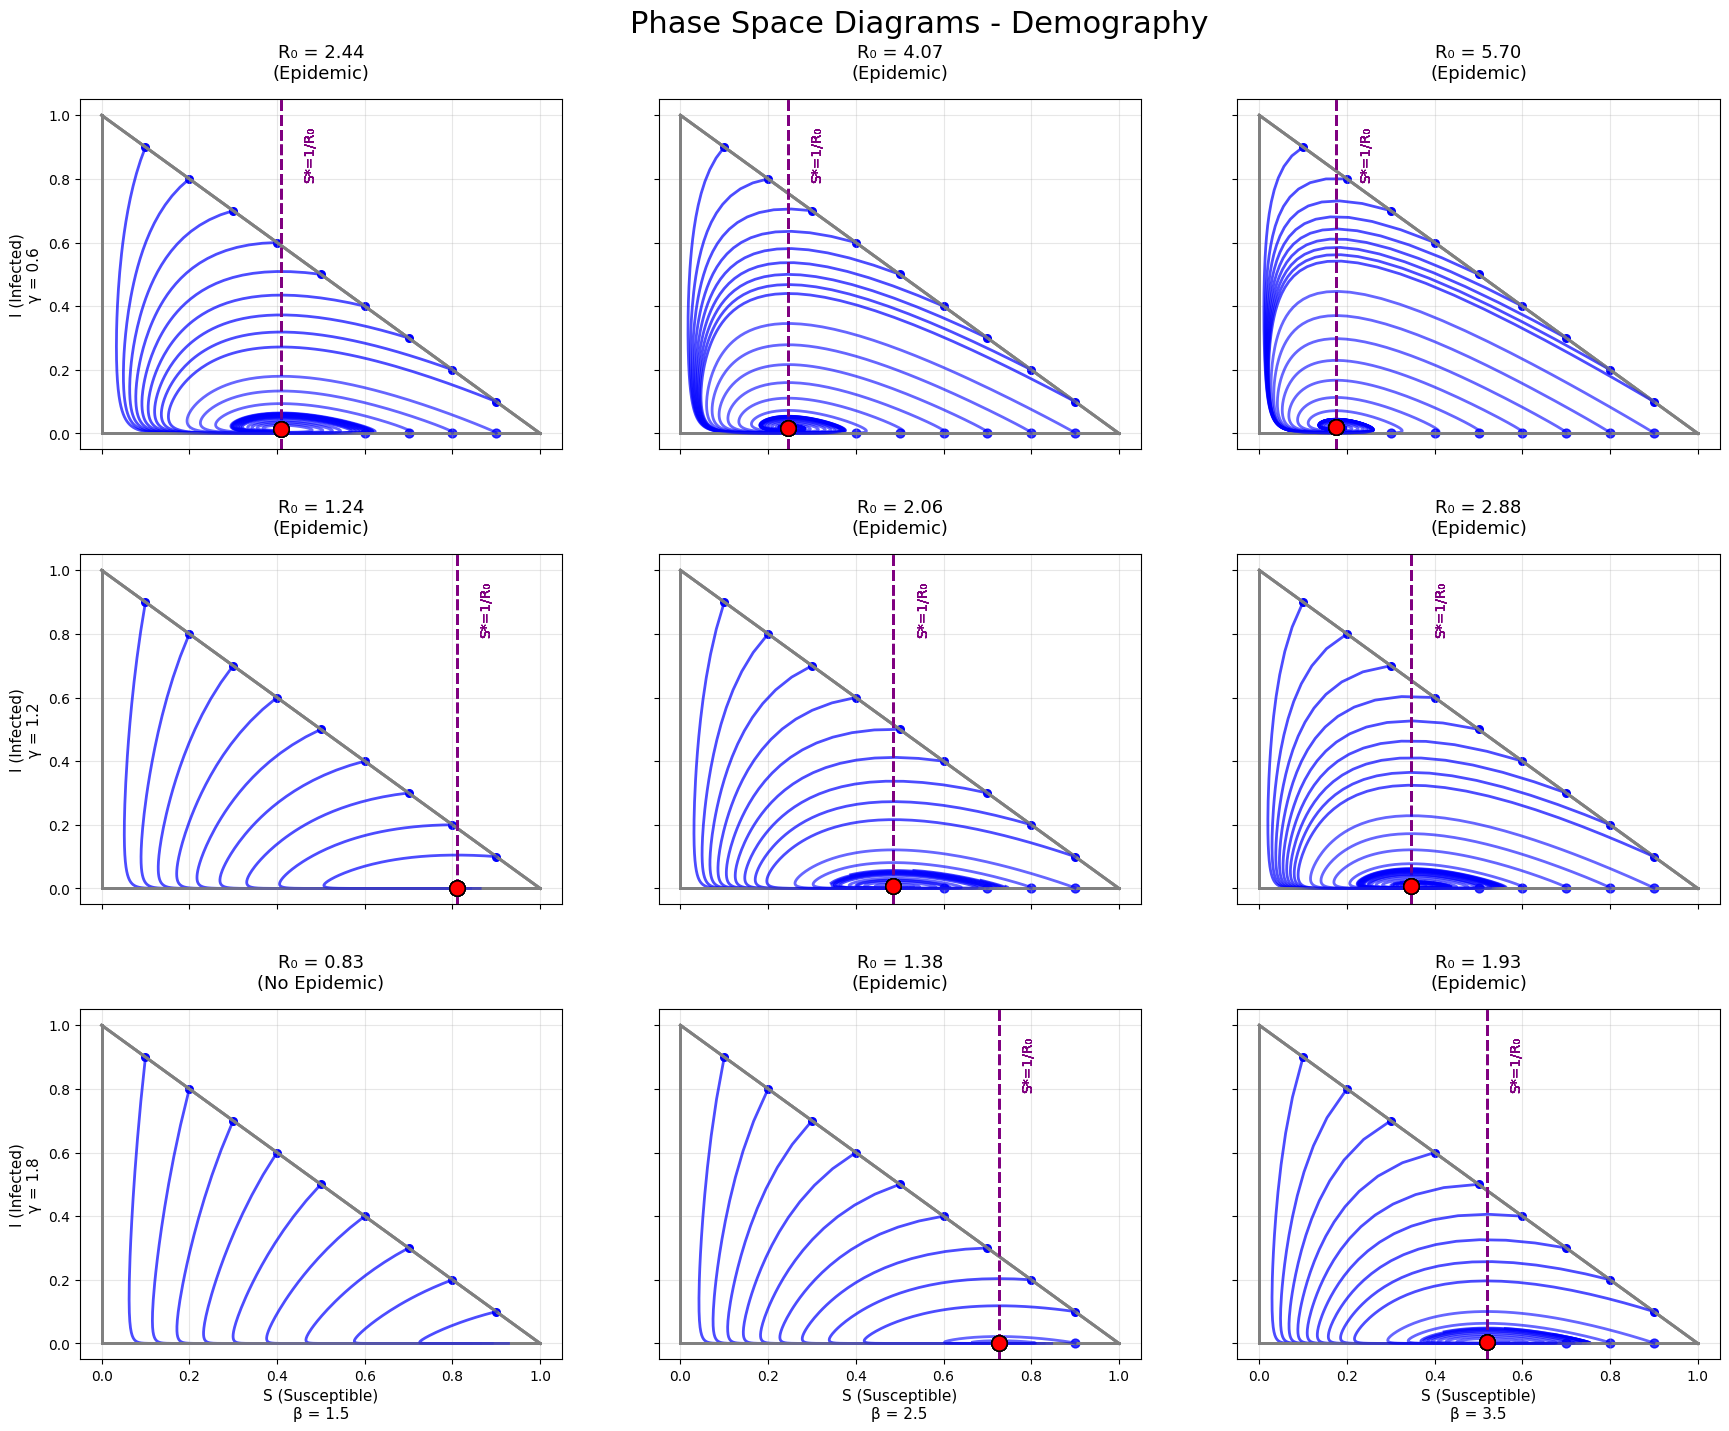

\n2.2 Oscillatory Behavior Analysis
Parameters: β=1.4247, γ=0.1429, μ=0.000039
R₀ = 9.97
Equilibrium: S*=0.1003, I*=0.000246, R*=0.8995


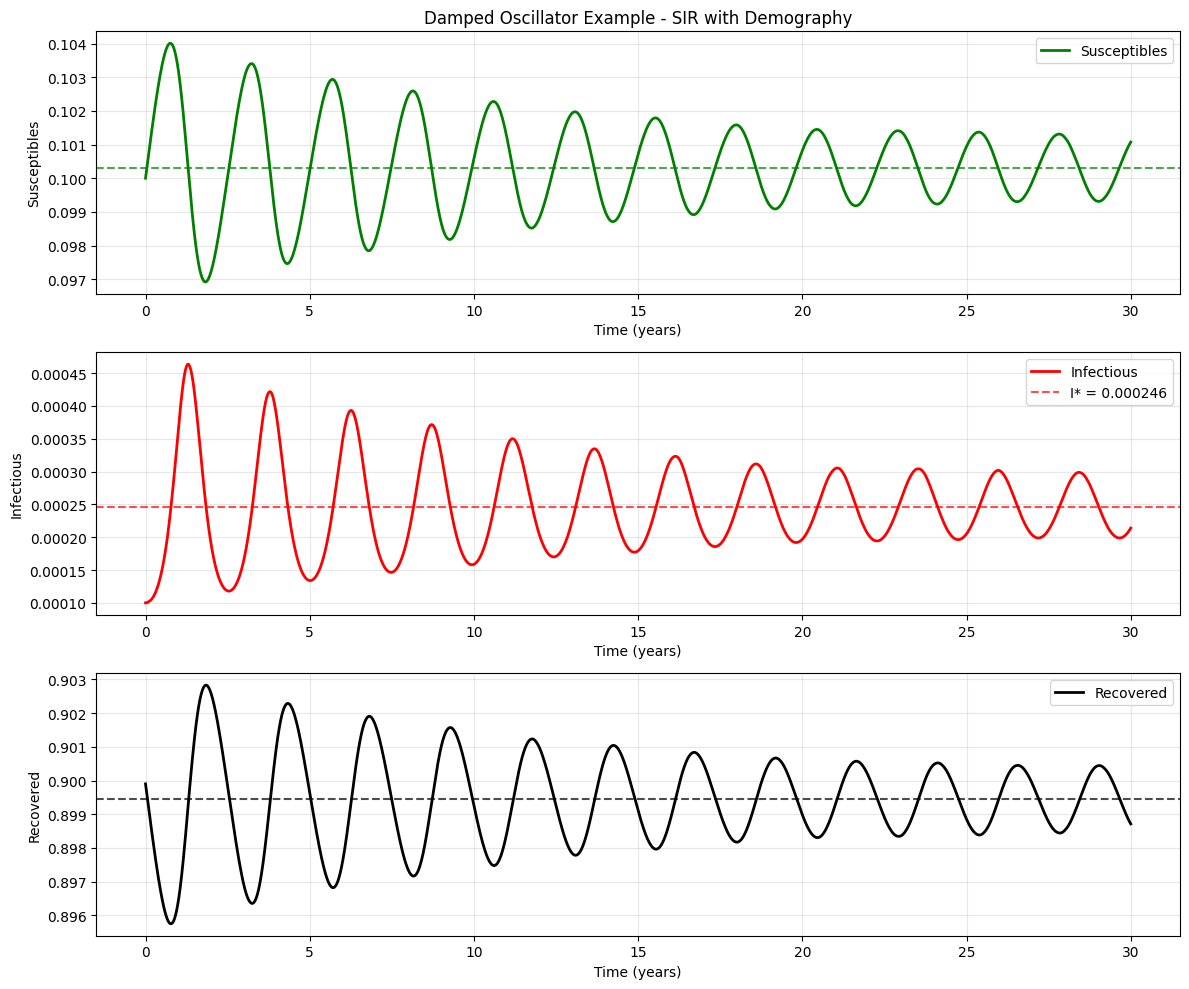

\n2.2.1 Fourier Analysis of Oscillations
----------------------------------------
Susceptible:
 Period: 2.40 years (876 days)
 Frequency: 0.42 cycles/year
 Amplitude: 0.002458
 Peak-to-peak period: 2.46 years

Infected:
 Period: 2.40 years (876 days)
 Frequency: 0.42 cycles/year
 Amplitude: 0.000147
 Peak-to-peak period: 2.46 years

Recovered:
 Period: 2.40 years (876 days)
 Frequency: 0.42 cycles/year
 Amplitude: 0.002455
 Peak-to-peak period: 2.47 years

Main oscillation period: 2.40 years
Main oscillation frequency: 0.42 cycles per year
Oscillation amplitude: 0.000147


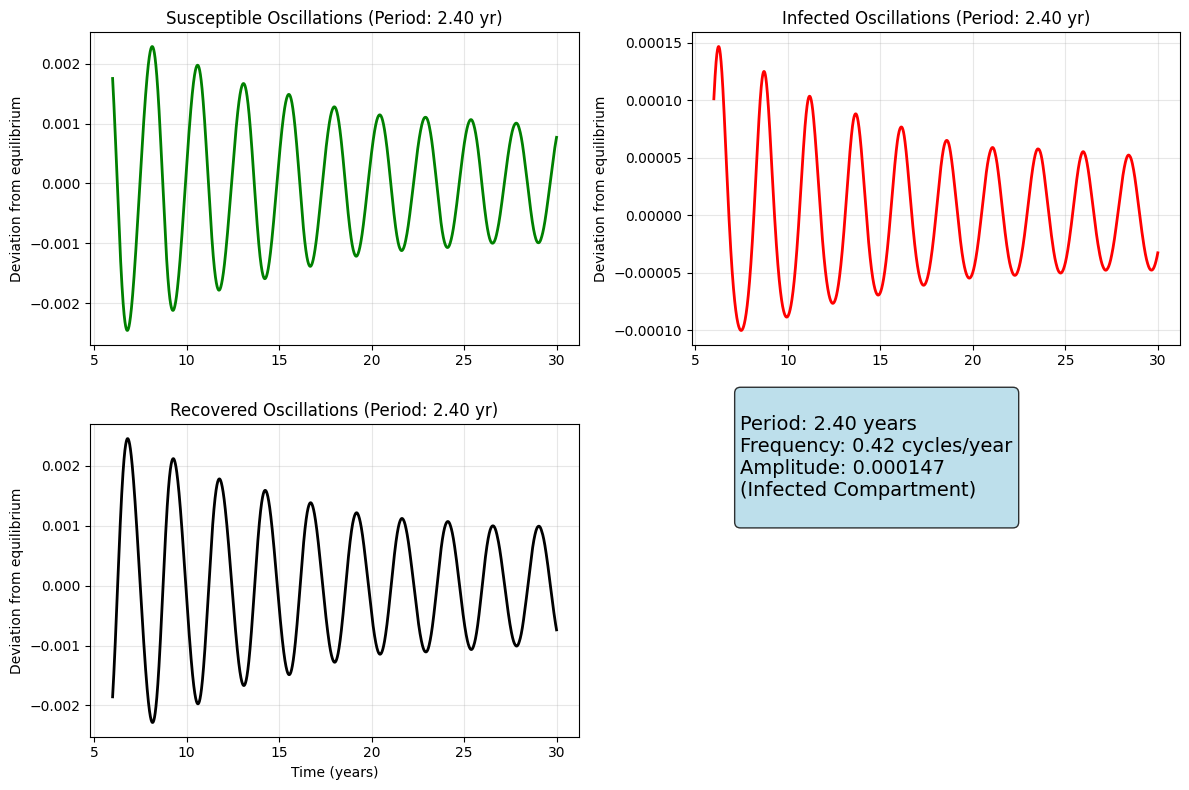


2.3 Infection-Induced Mortality Analysis


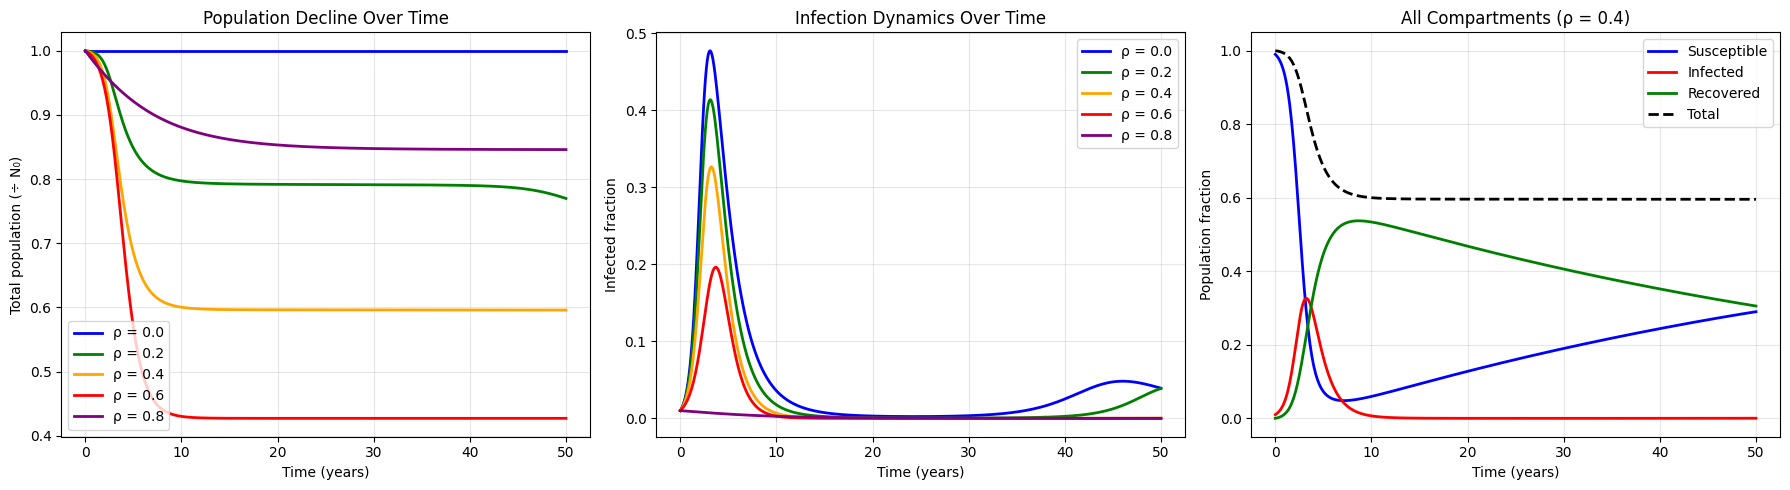

In [23]:
def p2():
    """
    Problem 2 Execution
    """
    print("Problem 2: Demography")

    print("\\n2.1 SIR Model with Birth and Death Rates")
    run_sir_demography_analysis()

    print("\\n2.2 Oscillatory Behavior Analysis")
    t_sol, S_sol, I_sol, R_sol, S_eq, I_eq, R_eq = run_oscillation_analysis()

    print("\\n2.2.1 Fourier Analysis of Oscillations")
    print("-" * 40)
    S_period, S_freq, S_amp = analyze_oscillations(t_sol, S_sol, S_eq, "Susceptible")
    I_period, I_freq, I_amp = analyze_oscillations(t_sol, I_sol, I_eq, "Infected")
    R_period, R_freq, R_amp = analyze_oscillations(t_sol, R_sol, R_eq, "Recovered")

    print(f"Main oscillation period: {I_period:.2f} years")
    print(f"Main oscillation frequency: {I_freq:.2f} cycles per year")
    print(f"Oscillation amplitude: {I_amp:.6f}")

    # Oscillation visualization
    pl.figure(figsize=(12, 8))
    skip = len(t_sol) // 5
    t_plot = t_sol[skip:] / 365

    pl.subplot(221)
    pl.plot(t_plot, S_sol[skip:] - S_eq, "g-", linewidth=2)
    pl.title(f"Susceptible Oscillations (Period: {S_period:.2f} yr)")
    pl.ylabel("Deviation from equilibrium")
    pl.grid(True, alpha=0.3)

    pl.subplot(222)
    pl.plot(t_plot, I_sol[skip:] - I_eq, "r-", linewidth=2)
    pl.title(f"Infected Oscillations (Period: {I_period:.2f} yr)")
    pl.ylabel("Deviation from equilibrium")
    pl.grid(True, alpha=0.3)

    pl.subplot(223)
    pl.plot(t_plot, R_sol[skip:] - R_eq, "k-", linewidth=2)
    pl.title(f"Recovered Oscillations (Period: {R_period:.2f} yr)")
    pl.xlabel("Time (years)")
    pl.ylabel("Deviation from equilibrium")
    pl.grid(True, alpha=0.3)

    pl.subplot(224)
    pl.axis("off")
    summary = f"""
Period: {I_period:.2f} years
Frequency: {I_freq:.2f} cycles/year
Amplitude: {I_amp:.6f}
(Infected Compartment)
"""
    pl.text(
        0.1,
        0.7,
        summary,
        fontsize=14,
        bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.8),
    )

    pl.tight_layout()
    pl.show()

    print("\n2.3 Infection-Induced Mortality Analysis")
    run_mortality_analysis()


p2()

### Problem 3

Problem 3: Variants of the SIR Model

3.1 SEIR Model Analysis


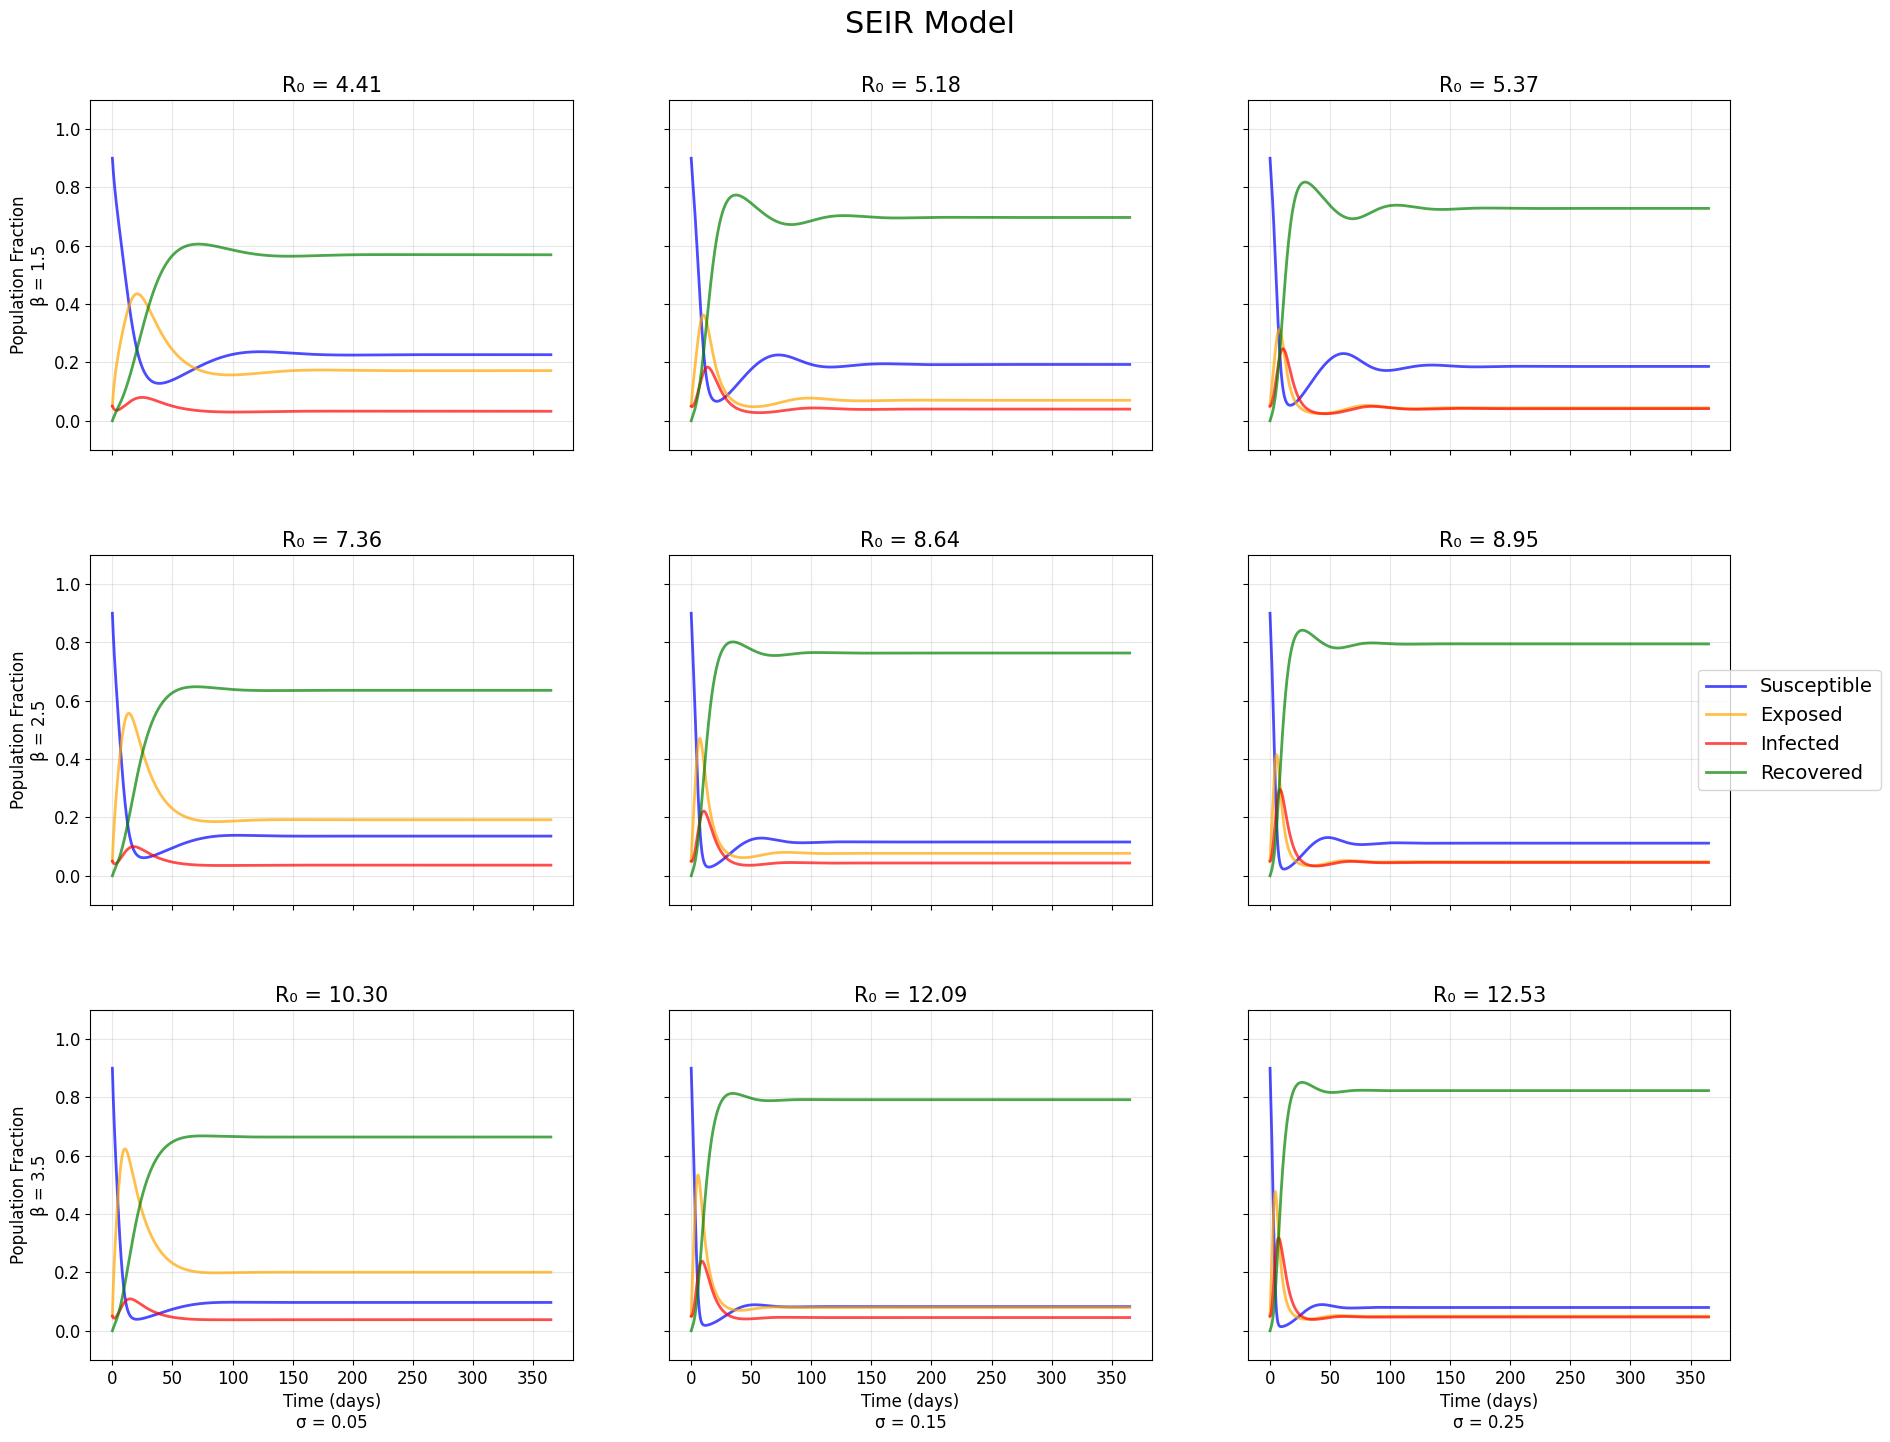


3.2 Seasonal Effects in SEIR Model


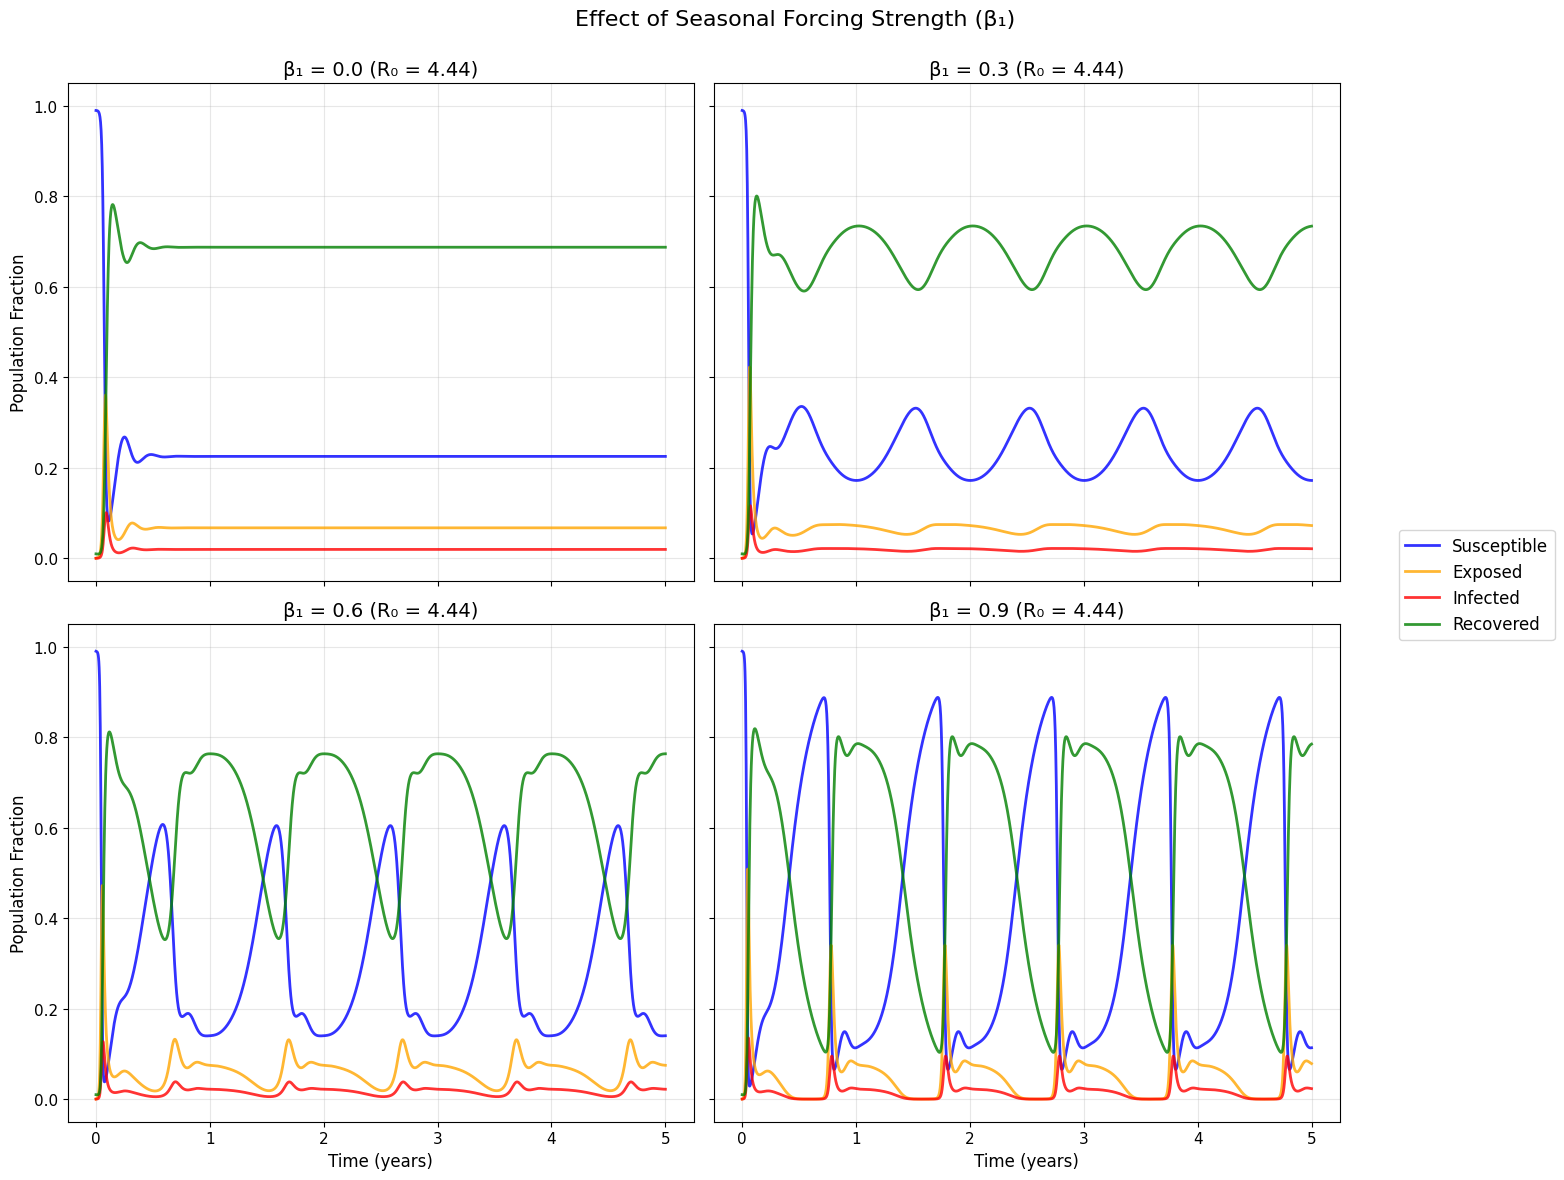

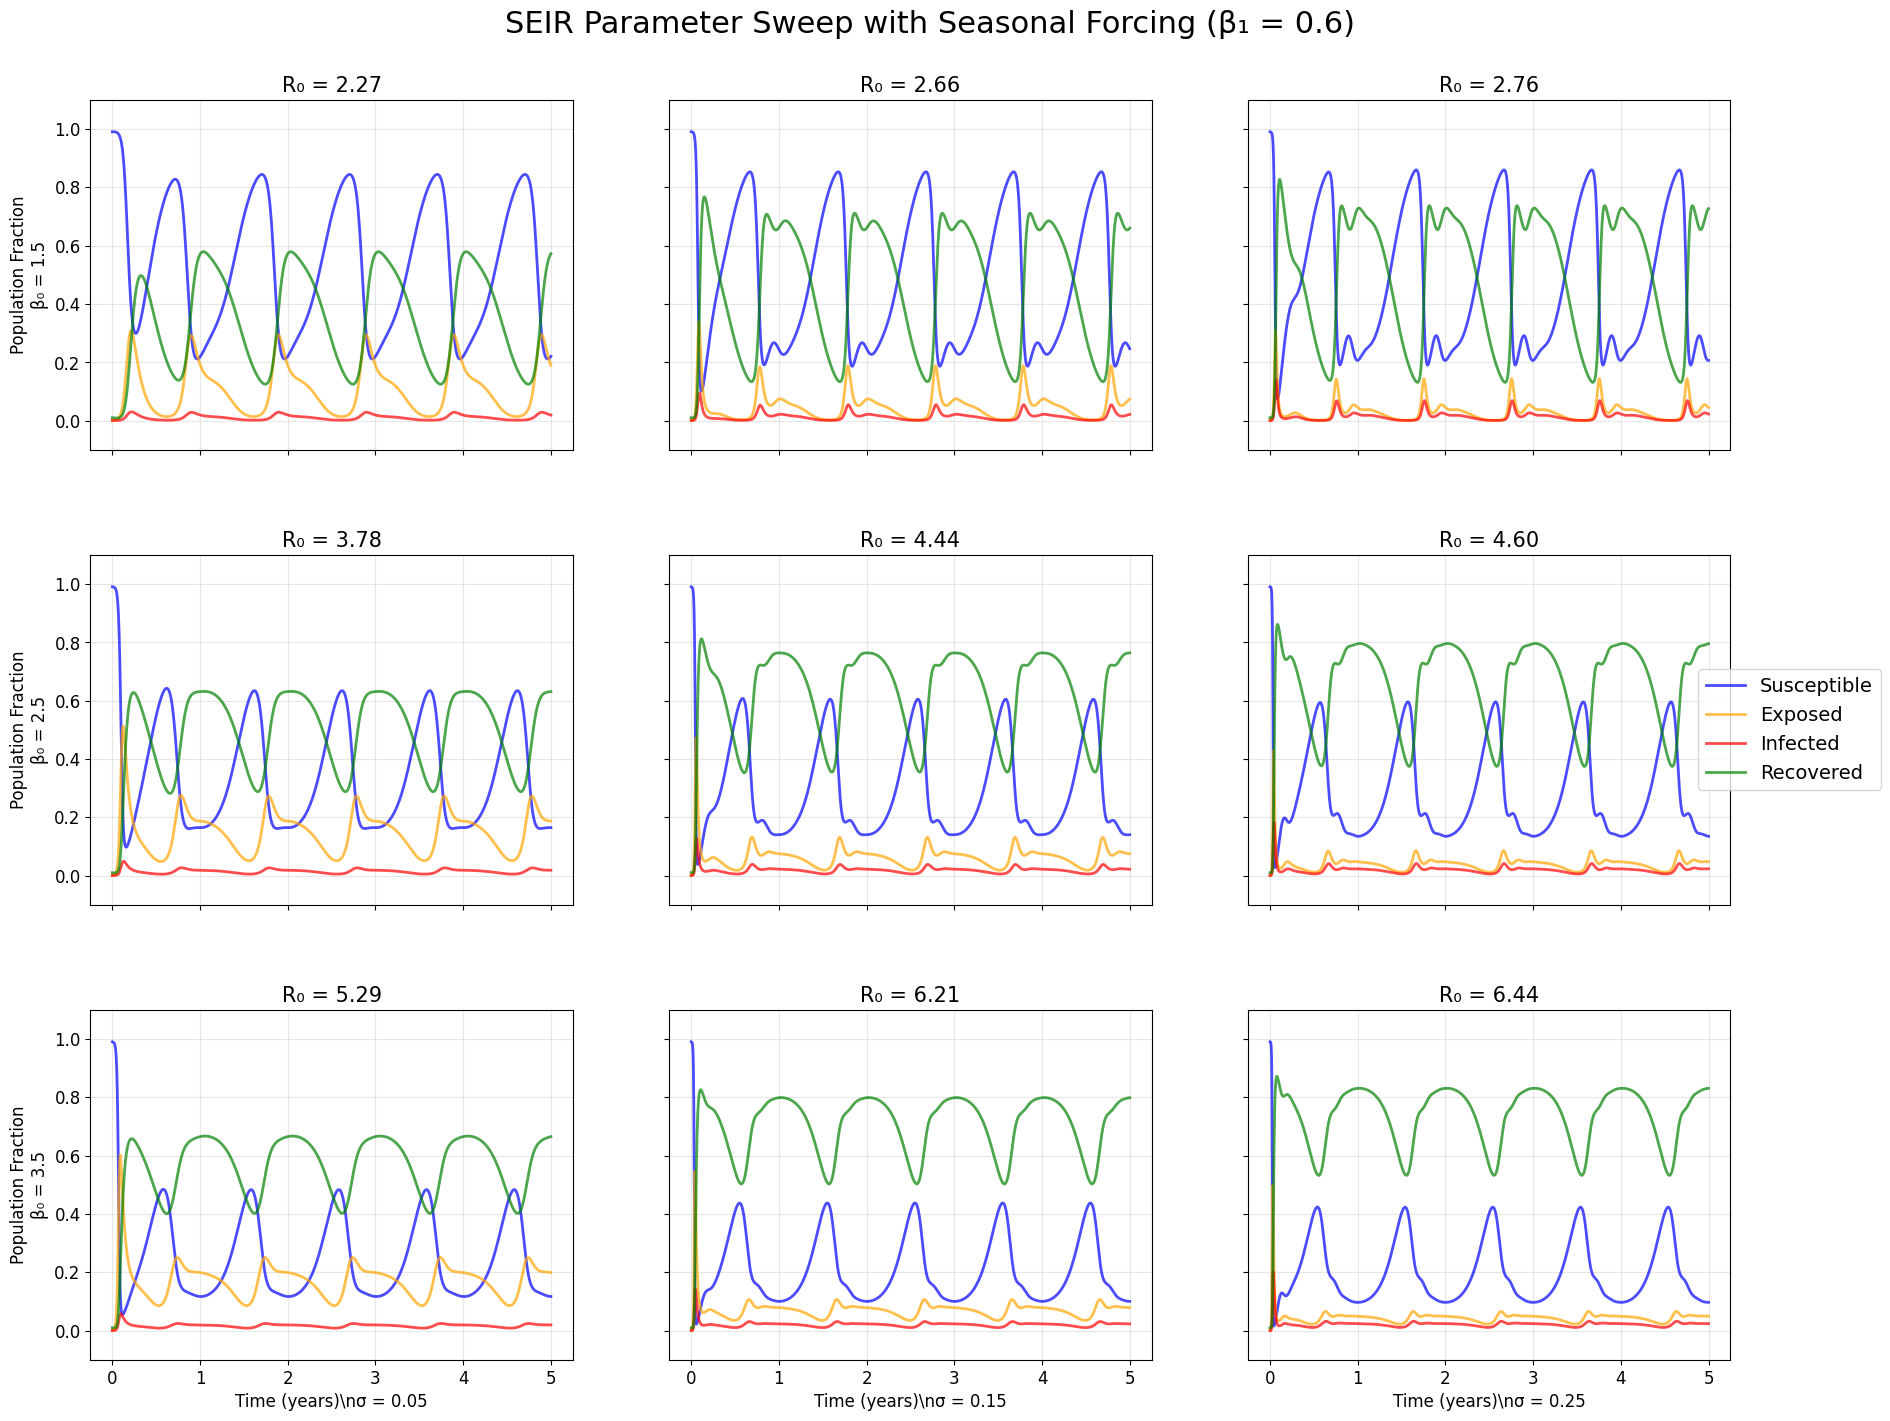

In [36]:
def p3():
    """
    Problem 3 execution
    """
    print("Problem 3: Variants of the SIR Model")
    print("\n3.1 SEIR Model Analysis")
    run_seir_analysis()

    print("\n3.2 Seasonal Effects in SEIR Model")
    run_seir_seasonal_analysis()


p3()